In [1]:
# --- Thư viện cốt lõi (Tính toán, Xử lý dữ liệu & Trực quan) ---
# Đây là các thư viện cơ bản cần thiết cho mọi phần của đồ án
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%config InlineBackend.figure_format = 'retina'

# --- Thư viện cho bài toán NMF cơ sở và Tiền xử lý dữ liệu (Sklearn) ---
# Dùng để tải dữ liệu (MNIST) và chạy NMF truyền thống bằng Scikit-learn
from sklearn.datasets import fetch_openml
from sklearn.decomposition import NMF as SklearnNMF
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.constraints import NonNeg # Ràng buộc trọng số không âm

# Tắt các cảnh báo (warnings)
import warnings
warnings.filterwarnings('ignore')

# Đồ án: Non-negative Matrix Factorization (NMF) - Lý Thuyết và Ứng Dụng

## 1. Giới thiệu: Non-negative Matrix Factorization (NMF)

+ **Non-negative Matrix Factorization (NMF)** là một phương pháp phân tích ma trận được sử dụng rộng rãi trong nhiều lĩnh vực như xử lý ảnh, xử lý ngôn ngữ tự nhiên (NLP), và sinh học.

+ Ý tưởng chính là phân tách một ma trận dữ liệu **không âm** $V$ thành hai ma trận nhỏ hơn là $W$ và $H$, sao cho:

$$
V \approx W \times H
$$



+ Ràng buộc quan trọng nhất là tất cả các phần tử của cả ba ma trận đều phải **không âm** ($V, W, H \ge 0$).

+ Điều này dẫn đến một "biểu diễn dựa trên phần tử" (parts-based representation), giúp NMF trích xuất các đặc trưng tiềm ẩn có ý nghĩa và dễ diễn giải hơn so với các kỹ thuật như PCA hay SVD.

## 2. Bài toán Non-negative Matrix Factorization (NMF)

Cho ma trận dữ liệu gốc $V \in \mathbb{R}^{m \times n}$, với $V \ge 0$.

Nhiệm vụ là tìm hai ma trận $W \in \mathbb{R}^{m \times k}$ và $H \in \mathbb{R}^{k \times n}$ sao cho $W, H \ge 0$ và $V \approx WH$.

* $k$ là số lượng thành phần (components) hay đặc trưng tiềm ẩn (latent features).
* Thường $k$ được chọn nhỏ hơn $m$ và $n$ để nén dữ liệu (giảm chiều).

Trong đó:
* $W$: Chứa các **cơ sở đặc trưng** (basis).
* $H$: Chứa các **hệ số kết hợp** (coefficients).

NMF được áp dụng trong **phân tích thống kê dữ liệu** và **học máy không giám sát**, nhằm biểu diễn tập dữ liệu gốc $V$ (với kích thước lớn) dưới dạng tích của hai ma trận nhỏ hơn, giúp **giảm chiều dữ liệu** mà vẫn giữ được thông tin chính.


### 2.1 Mô tả trực quan:
+ Giả sử mỗi cột của ma trận $ V$ là một vector dữ liệu mẫu.  
+ NMF tìm cách biểu diễn mỗi vector dữ liệu đó như **tổ hợp tuyến tính không âm** của các vector trong $W$:
$$v_i \approx W h_i$$
với $h_i \ge 0$ là cột tương ứng trong $H$.


## 3. Các Hàm Mất Mát (Loss Functions)

+ Để "đo" mức độ xấp xỉ $V \approx WH$, chúng ta cần định nghĩa một hàm mất mát (Loss Function) $D(V || WH)$. Bài toán NMF trở thành bài toán tối ưu:

$$
\min_{W, H \ge 0} D(V || WH)
$$

+ Đồ án này tập trung vào 3 hàm mất mát chính:
  + **Chuẩn Frobenius (Frobenius Norm)**
  + **Độ phân kỳ Kullback-Leibler (KL Divergence)**
  + **Độ phân kỳ Itakura-Saito (IS Divergence)**

## 4. Tải và Chuẩn bị Dữ liệu (MNIST)

+ Chúng ta sẽ thực nghiệm trên bộ dữ liệu chữ số viết tay MNIST.

In [2]:
# Tải bộ dữ liệu MNIST
try:
    from tensorflow.keras.datasets import mnist
    (X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()
    # Gộp tập train và test lại thành một bộ dữ liệu X, y
    X = np.concatenate((X_train_full, X_test_full), axis=0)
    y = np.concatenate((y_train_full, y_test_full), axis=0)

    # Reshape từ (N, 28, 28) thành (N, 784)
    X = X.reshape((X.shape[0], -1))

except ImportError:
    # Phương án 2: Tải từ OpenML nếu không thể sử dụng Tensorflow/Keras
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    X = mnist.data
    y = mnist.target

# Chuẩn hóa pixel về [0,1] để thỏa mãn ràng buộc ma trận không âm
# Sử dụng MinMaxScaler để thực hiện tiền xử lí dữ liệu
scaler = MinMaxScaler()
V = scaler.fit_transform(X)

# Lấy một tập con (10000 mẫu) để tăng tốc độ huấn luyện
V, y = V[:10000], y[:10000]

n_samples, n_features = V.shape
image_shape = (28, 28)

print(f"Kích thước ma trận V (Samples x Features): {V.shape}")
print(f"Tổng số mẫu: {n_samples}, Tổng số đặc trưng: {n_features}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Kích thước ma trận V (Samples x Features): (10000, 784)
Tổng số mẫu: 10000, Tổng số đặc trưng: 784


## 5. Phân tích và Trực quan hóa Dữ liệu (Data Visualization)
+ Sử dụng thư viện Matplotlib để kiểm tra trực quan các mẫu dữ liệu đầu vào (Ma trận $V$).

In [3]:
def plot_gallery(title, images, image_shape, n_col=5, n_row=3, cmap=plt.cm.gray):
    # Hàm tiện ích để vẽ các ảnh/components
    plt.figure(figsize=(1.8 * n_col, 2.0 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(comp.reshape(image_shape), cmap=cmap, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.88, 0.04, 0.)

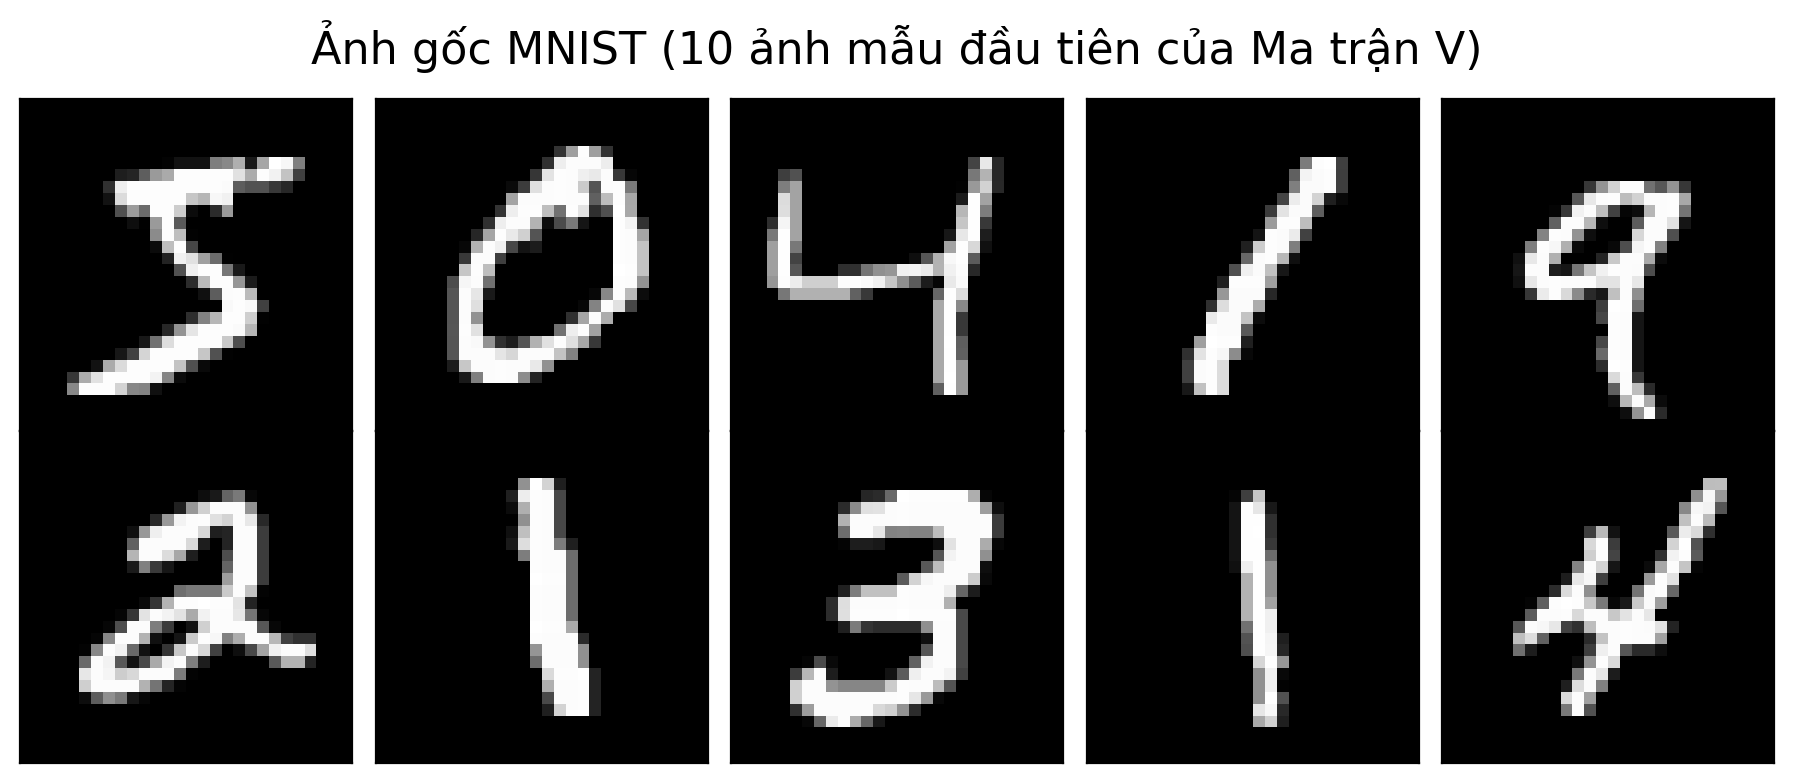

In [4]:
# Hiển thị 10 ảnh gốc đầu tiên
plot_gallery("Ảnh gốc MNIST (10 ảnh mẫu đầu tiên của Ma trận V)", V[:10], image_shape, n_col=5, n_row=2)
plt.show()

## 6. Thực nghiệm 1: Đánh giá, triển khai và so sánh các hàm mục tiêu (Loss Functions) cho bài toán Non-negative Matrix Factorization (NMF)
✍️ Giới thiệu Thực nghiệm 1:
+ Mục tiêu chính của thực nghiệm này là đi sâu vào bản chất của NMF. Thay vì sử dụng thư viện sklearn như một "hộp đen", chúng ta sẽ tự triển khai (from scratch) các thành phần cốt lõi của thuật toán.
+ Chúng ta sẽ tập trung vào 3 khía cạnh:
  + Triển khai Công thức: Chuyển đổi các công thức toán học phức tạp của Quy tắc Cập nhật Nhân (Multiplicative Update Rules - MUR) cho cả ba hàm mất mát (Frobenius, KL, và IS) thành mã Python.
  + Quan sát Hội tụ: Trực quan hóa đường cong mất mát (loss curve) để xác nhận rằng các quy tắc cập nhật của chúng ta thực sự tối ưu hóa (giảm) hàm mục tiêu theo thời gian.
  + Phân tích Đặc trưng: So sánh trực quan các "ảnh cơ sở" (basis images) mà mỗi hàm mất mát học được (chính là các hàng của ma trận $H$).
+ Để đảm bảo tốc độ minh họa, thực nghiệm "from scratch" này sẽ chỉ chạy trên một tập dữ liệu con (subset) gồm 3.000 mẫu. Các kết quả quan sát được từ đây sẽ làm cơ sở để so sánh với thực nghiệm quy mô lớn hơn (trên toàn bộ 10.000 mẫu) bằng sklearn ở Mục 7.


### 6.1 Giới thiệu phân kỳ Frobenius:
#### 6.1.1 Hàm mất mát (Loss Function)

+ Sai số giữa ma trận gốc $V$ và ma trận tái tạo $WH$ thường được đo bằng **chuẩn Frobenius**:

$$
\|V - WH\|_F^2 = \sum_{i=1}^{m}\sum_{j=1}^{n} (v_{ij} - (WH)_{ij})^2
$$


+ Do đó, bài toán NMF được viết lại dưới dạng tối ưu hóa:

$$
\min_{W,H \ge 0} \; \|V - WH\|_F^2
$$

#### 6.1.2 Giải thích:
- Chuẩn Frobenius đo **khoảng cách giữa hai ma trận**.
- Khi \($\|V - WH\|_F^2$\) càng nhỏ, thì $W$ và $H$ càng mô tả chính xác dữ liệu ban đầu.
- NMF phù hợp khi dữ liệu mang tính **không âm** (như cường độ ảnh, tần suất từ, hoặc âm lượng).
#### 6.1.3 Công thức chuẩn Frobenius:
+ Cho ma trận $A \in \mathbb{R}^{m \times n}$, ta có:
$$ \|A\|_F = \sqrt{\sum_{i=1}^{m} \sum_{j=1}^{n} a_{ij}^2} $$
#### 6.1.4 Ví dụ đơn giản về phân kỳ Frobenius:
+ Ví dụ về chuẩn Frobenius của 1 ma trận A:


In [5]:
A = np.array([[1, 2], [3, 4]])
fro_norm = np.linalg.norm(A, 'fro')
print(f"Chuẩn Frobenius của A: {fro_norm}")

Chuẩn Frobenius của A: 5.477225575051661


### 6.2 Giới thiệu phân kỳ Kullback-Leibler
#### 6.2.1 Hàm mất mát (Loss Function)
+ Sai số giữa ma trận gốc $V$ và ma trận tái tạo $WH$ cũng thường được đo bằng Phân kỳ Kullback-Leibler:$$D_{KL}(V || WH) = \sum_{i=1}^{m}\sum_{j=1}^{n} \left( V_{ij} \log\frac{V_{ij}}{(WH)_{ij}} - V_{ij} + (WH)_{ij} \right)$$

+ Do đó, bài toán NMF được viết lại dưới dạng tối ưu hóa:$$\min_{W,H \ge 0} \; D_{KL}(V || WH)$$
#### 6.2.2 Giải thích:
+ Phân kỳ KL đo sự khác biệt về mặt thông tin (divergence) giữa hai phân phối dữ liệu ($V$ và $WH$).
+ Khi $D_{KL}(V || WH)$ càng nhỏ, thì $WH$ càng xấp xỉ tốt hơn với phân phối dữ liệu gốc $V$.
+ NMF phù hợp khi dữ liệu mang tính không âm. Phân kỳ KL đặc biệt hiệu quả cho dữ liệu đếm (count data), chẳng hạn như tần suất từ trong văn bản.
#### 6.2.3 Công thức phân kỳ Kullback-Leibler:
+ Cho hai ma trận không âm $A$ và $B$ (cùng kích thước $m \times n$), ta có:$$ D_{KL}(A || B) = \sum_{i=1}^{m} \sum_{j=1}^{n} \left( A_{ij} \log\frac{A_{ij}}{B_{ij}} - A_{ij} + B_{ij} \right) $$
#### 6.2.4 Ví dụ đơn giản về tính toán độ phân kỳ Kullback-Leibler:
+ Ví dụ về tính phân kỳ Kullback-Leibler:

In [6]:
def kl_divergence(V, W):
    """
    Tính Phân kỳ Kullback-Leibler.
    """
    # Thêm một hằng số rất nhỏ (epsilon) để tránh lỗi chia cho 0 hoặc log(0)
    epsilon = 1e-10

    # Tính tổng của (W_ij - V_ij)
    kl_div = np.sum(W - V)

    # Chỉ tính V * log(V/W) cho các phần tử V_ij > 0
    # (vì khi V_ij = 0, thì V_ij * log(V_ij) = 0)
    V_gt_0 = V > 0

    # Thêm epsilon vào W[V_gt_0] để tránh chia cho 0 nếu W_ij = 0
    kl_div += np.sum(V[V_gt_0] * np.log(V[V_gt_0] / (W[V_gt_0] + epsilon)))

    return kl_div

# Giữ V là ma trận A của bạn (ma trận gốc)
V_Example = np.array([[1, 2], [3, 4]])

# Phân kỳ KL cần ma trận thứ hai (giả sử là WH)
# Chúng ta tạo một ma trận W (tức là WH) gần giống V để so sánh
W = np.array([[1.1, 1.9], [2.9, 4.1]])

# Tính toán phân kỳ KL
kl_div = kl_divergence(V_Example, W)

print(f"Ma trận V (gốc):\n{V_Example}")
print(f"Ma trận W (tái tạo):\n{W}")
print(f"Phân kỳ KL (D_KL(V || W)): {kl_div}")

Ma trận V (gốc):
[[1 2]
 [3 4]]
Ma trận W (tái tạo):
[[1.1 1.9]
 [2.9 4.1]]
Phân kỳ KL (D_KL(V || W)): 0.01021061323915258


### 6.3 Giới thiệu phân kỳ Itakura-Saito (IS)
#### 6.3.1 Hàm mất mát (Loss Function)
+ Ngoài Frobenius và KL, phân kỳ Itakura-Saito (IS) là một hàm mất mát quan trọng khác, đặc biệt trong lĩnh vực xử lý âm thanh. Hàm mục tiêu là tối thiểu hóa $D_{IS}(V || WH)$. Công thức này yêu cầu các giá trị $V_{ij}$ và $(WH)_{ij}$ phải lớn hơn 0:$$D_{IS}(V || WH) = \sum_{i=1}^{m}\sum_{j=1}^{n} \left( \frac{V_{ij}}{(WH)_{ij}} - \log\frac{V_{ij}}{(WH)_{ij}} - 1 \right)$$Do đó, bài toán NMF được viết lại dưới dạng tối ưu hóa:$$\min_{W,H \ge 0} \; D_{IS}(V || WH)$$
#### 6.3.2 Giải thích:
+ Phân kỳ IS (là một trường hợp đặc biệt của beta-divergence khi $\beta=0$) đo lường sự khác biệt về cấu trúc giữa $V$ và $WH$.
+ Tính chất quan trọng nhất của IS là bất biến với tỷ lệ (scale-invariant). Nghĩa là, nếu $V$ và $WH$ cùng được nhân với một hằng số (ví dụ: âm lượng tổng thể tăng lên), thì giá trị phân kỳ (sai số) không đổi.
+ Do tính chất này, IS rất phù hợp cho xử lý tín hiệu âm thanh (ví dụ: tách nguồn nhạc, phân tích spectrogram), nơi hình dạng quang phổ (spectral shape) quan trọng hơn cường độ tuyệt đối (âm lượng).
+ Lưu ý quan trọng: Phân kỳ IS yêu cầu tất cả các phần tử $V_{ij}$ và $(WH)_{ij}$ phải lớn hơn 0 (strictly positive) do có cả phép chia và logarit. Khi áp dụng, dữ liệu $V$ có giá trị bằng 0 cần được xử lý (ví dụ: thêm một giá trị epsilon rất nhỏ).
#### 6.3.3 Công thức phân kỳ Itakura-Saito:
+ Cho hai ma trận không âm $A$ và $B$ (cùng kích thước $m \times n$, với các phần tử $A_{ij}, B_{ij} > 0$), ta có:$$D_{IS}(A || B) = \sum_{i=1}^{m} \sum_{j=1}^{n} \left( \frac{A_{ij}}{B_{ij}} - \log\frac{A_{ij}}{B_{ij}} - 1 \right)$$
#### 6.3.4 Các đặc điểm quan trọng của độ phân kỳ Itakura-Saito:
1.  **Nhạy với sai số TỈ LỆ:** IS phạt nặng các sai số có *tỉ lệ* lớn.
    * Ví dụ: Sai số $D_{IS}(20 || 10)$ (tái tạo 10, lẽ ra là 20 -> lệch 50%) sẽ bị phạt **nặng hơn** $D_{IS}(100 || 90)$ (tái tạo 90, lẽ ra là 100 -> chỉ lệch 10%).
    * Frobenius ngược lại, sẽ phạt $D(100 || 90)$ nặng hơn $D(20 || 10)$ (vì $100-90 > 20-10$).

2.  **Bất biến với thang đo:** Nếu nhân toàn bộ dữ liệu $V$ và xấp xỉ $WH$ cùng với 1 hằng số $\alpha > 0$, giá trị $D_{IS}(\alpha V || \alpha WH)$ **không đổi**.
#### 6.3.5 Ví dụ minh họa về đặc điểm của độ phân kỳ Itakura-Saito:
+ Ví dụ chứng minh độ phân kỳ Itakura-Saito rất nhạy với sai số tỉ lệ và bất biến với thang đo:

In [7]:
import numpy as np

def is_divergence_scalar(x, y):
    """Tính IS divergence cho 2 số."""
    # Thêm epsilon để tránh chia cho 0
    x = x + 1e-10
    y = y + 1e-10
    ratio = x / y
    return ratio - np.log(ratio) - 1

# 1. Chứng minh: Nhạy với sai số TỈ LỆ
err_is_1 = is_divergence_scalar(20, 10) # Tỉ lệ 2.0 (Lệch 50%)
err_is_2 = is_divergence_scalar(100, 90) # Tỉ lệ 1.11 (Lệch 10%)

print("--- Chứng minh 1: Nhạy với Tỉ lệ ---")
print(f"Lỗi IS (20 vs 10): {err_is_1:.4f} (Rất cao)")
print(f"Lỗi IS (100 vs 90): {err_is_2:.4f} (Rất thấp)")

# 2. Chứng minh: Bất biến với thang đo
def is_divergence_matrix(V, W):
    """Tính IS divergence cho 2 ma trận."""
    epsilon = 1e-10
    ratio = (V + epsilon) / (W + epsilon)
    return np.sum(ratio - np.log(ratio) - 1)

V_Example = np.array([[1, 2], [3, 4]])
W = np.array([[0.8, 2.2], [2.5, 4.1]])
alpha = 10.0 # Hằng số alpha

loss_1 = is_divergence_matrix(V_Example, W)
loss_2 = is_divergence_matrix(alpha * V_Example, alpha * W)

print("\n--- Chứng minh 2: Bất biến với Thang đo ---")
print(f"Loss gốc D(V || W): {loss_1:.4f}")
print(f"Loss khi nhân với {alpha}, D(aV || aW): {loss_2:.4f} (Giống nhau)")

--- Chứng minh 1: Nhạy với Tỉ lệ ---
Lỗi IS (20 vs 10): 0.3069 (Rất cao)
Lỗi IS (100 vs 90): 0.0058 (Rất thấp)

--- Chứng minh 2: Bất biến với Thang đo ---
Loss gốc D(V || W): 0.0492
Loss khi nhân với 10.0, D(aV || aW): 0.0492 (Giống nhau)


### 6.4 Triển khai hàm khởi tạo (Initialization) và ba hàm mất mát (Loss Functions)

#### 6.4.1 Hàm Khởi tạo (Initialization)

+ Việc khởi tạo $W$ và $H$ là một bước quan trọng, ảnh hưởng trực tiếp đến tốc độ hội tụ. Trong khuôn khổ của bài thực nghiệm này, chúng ta sử dụng phương pháp khởi tạo ngẫu nhiên đơn giản (Simple Random Initialization) vì đây là cách tiếp cận cơ bản và trực quan nhất để bắt đầu triển khai thuật toán.

In [8]:
def initialize_wh(V, k, random_state=42):
    """
    Khởi tạo W và H dùng phương pháp khởi tạo ngẫu nhiên đơn giản
    nhưng được chuẩn hóa (scale) dựa trên trung bình của V.
    """
    eps = 1e-6
    rng = np.random.RandomState(random_state)
    m, n = V.shape

    # Khởi tạo ngẫu nhiên
    W = rng.rand(m, k)
    H = rng.rand(k, n)

    # Chuẩn hóa (scale) H dựa trên V (giống chiến lược của sklearn)
    W = np.maximum(W, eps)
    H = np.maximum(H * np.sqrt(V.mean() / (W.mean() * H.mean())), eps)

    return W, H

#### 6.4.2 Triển khai các hàm mất mát (Loss Functions)
+ Chúng ta định nghĩa các hàm để tính toán giá trị mất mát (Cost) tại mỗi vòng lặp.

##### 6.4.2.1 Phân kỳ Frobenius:

In [9]:
def frobenius_loss(V, W, H):
    """
    Tính toán hàm mất mát Frobenius Norm.
    """
    # .ravel() làm phẳng ma trận để tính tổng bình phương hiệu quả
    return 0.5 * np.sum((V - (W @ H))**2)

##### 6.4.2.2 Phân kỳ Kullback-Leibler:

In [10]:
def kl_divergence_loss(V, W, H, epsilon=1e-9):
    """
    Tính toán hàm mất mát Kullback-Leibler (KL) Divergence.
    """
    WH = W @ H + epsilon # Thêm epsilon để tránh log(0) hoặc chia cho 0

    # Tách riêng các thành phần để tránh lỗi
    V_WH = V / WH
    log_V_WH = np.log(V_WH + epsilon) # Thêm epsilon

    # Tính tổng các thành phần
    loss = np.sum(V * log_V_WH - V + WH)
    return loss

##### 6.4.2.3 Phân kỳ Itakura-Saito:

In [11]:
def is_divergence_loss(V, W, H, epsilon=1e-9):
    """
    Tính toán hàm mất mát Itakura-Saito (IS) Divergence.
    """
    WH = W @ H + epsilon
    V_WH = V / WH

    # Thêm epsilon nhỏ vào log để đảm bảo V_WH > 0 (nếu V có giá trị 0)
    log_V_WH = np.log(V_WH + epsilon)

    loss = np.sum(V_WH - log_V_WH - 1)
    return loss

### 6.5 Các Quy tắc Cập nhật Nhân (Multiplicative Update Rules - MUR)

+ Đây là lõi của thuật toán NMF. Chúng ta sẽ định nghĩa các hàm cập nhật riêng biệt cho từng hàm loss.

#### 6.5.1 Quy tắc cập nhập nhân cho phân kỳ Frobenius:
+ Công thức cập nhật (MUR) cho Frobenius (Lee & Seung 2001):

$$
H \leftarrow H \odot \frac{W^T V}{W^T W H}
$$
$$
W \leftarrow W \odot \frac{V H^T}{W H H^T}
$$
(trong đó $\odot$ là phép nhân theo từng phần tử - element-wise multiplication)

In [12]:
def update_frobenius(V, W, H, epsilon=1e-9):
    """
    Thực hiện một bước cập nhật W và H theo quy tắc Frobenius.
    """
    # Cập nhật H
    num_H = W.T @ V
    den_H = W.T @ W @ H + epsilon
    H = H * (num_H / den_H)

    # Cập nhật W
    num_W = V @ H.T
    den_W = W @ H @ H.T + epsilon
    W = W * (num_W / den_W)

    return W, H

#### 6.5.2 Quy tắc cập nhập nhân cho phân kỳ Kullback-Leibler (KL) Divergence

+ Công thức cập nhật (MUR) cho Kullback-Leibler (Lee & Seung 2001):

$$
H_{kj} \leftarrow H_{kj} \frac{\sum_{i} W_{ik} (V_{ij} / (WH)_{ij})}{\sum_{i} W_{ik}}
$$
$$
W_{ik} \leftarrow W_{ik} \frac{\sum_{j} H_{kj} (V_{ij} / (WH)_{ij})}{\sum_{j} H_{kj}}
$$

In [13]:
def update_kl(V, W, H, epsilon=1e-9):
    """
    Thực hiện một bước cập nhật W và H theo quy tắc KL.
    """
    WH = W @ H + epsilon

    # Cập nhật H
    # Tử số: W.T @ (V / WH) -> (k, m) @ (m, n) = (k, n)
    num_H = W.T @ (V / WH)
    # Mẫu số: W.sum(axis=0) -> (k,) -> reshape (k, 1)
    den_H = W.sum(axis=0).reshape(-1, 1) + epsilon
    H = H * (num_H / den_H)

    # Cập nhật W
    # Cần tính lại WH vì H đã thay đổi
    WH = W @ H + epsilon
    # Tử số: (V / WH) @ H.T -> (m, n) @ (n, k) = (m, k)
    num_W = (V / WH) @ H.T
    # Mẫu số: H.sum(axis=1) -> (k,) -> reshape (1, k)
    den_W = H.sum(axis=1).reshape(1, -1) + epsilon
    W = W * (num_W / den_W)

    return W, H

#### 6.5.3 Quy tắc cập nhập nhân cho phân kỳ Itakura-Saito (IS) Divergence

+ Công thức cập nhập (MUR) cho Itakura-Saito (Févotte & Idier, 2011):

$$
H_{a,b} \leftarrow H_{a,b} \cdot \left( \frac{\sum_{i} W_{i,a} V_{i,b} / (WH)_{i,b}^2}{\sum_{i} W_{i,a} / (WH)_{i,b}} \right)
$$
$$
W_{i,a} \leftarrow W_{i,a} \cdot \left( \frac{\sum_{b} H_{a,b} V_{i,b} / (WH)_{i,b}^2}{\sum_{b} H_{a,b} / (WH)_{i,b}} \right)
$$


In [14]:
def update_is(V, W, H, epsilon=1e-9):
    """
    Thực hiện một bước cập nhật W và H theo quy tắc IS.
    Lưu ý: V phải > 0 (V = V + epsilon)
    """

    # Cập nhật H
    WH = W @ H + epsilon
    WH_neg1 = 1.0 / WH # (WH)^-1
    WH_neg2 = 1.0 / (WH**2) # (WH)^-2

    V_WH2 = V * WH_neg2

    num_H = W.T @ V_WH2
    den_H = W.T @ WH_neg1 + epsilon

    H = H * np.sqrt(num_H / den_H)

    # Cập nhật W
    # Tính lại các thành phần vì H đã thay đổi
    WH = W @ H + epsilon
    WH_neg1 = 1.0 / WH
    WH_neg2 = 1.0 / (WH**2)

    V_WH2 = V * WH_neg2

    num_W = V_WH2 @ H.T
    den_W = WH_neg1 @ H.T + epsilon

    W = W * np.sqrt(num_W / den_W)

    return W, H

### 6.6 Tìm số thành phần tối ưu (k) bằng Phương pháp Elbow

Trước khi đi sâu vào so sánh 3 hàm mất mát, chúng ta cần trả lời câu hỏi quan trọng nhất: **Nên sử dụng bao nhiêu thành phần (k)?**

* Nếu `k` quá nhỏ, mô hình sẽ không nắm bắt được đủ thông tin (underfitting).
* Nếu `k` quá lớn, mô hình sẽ bị dư thừa, tốn kém chi phí tính toán, và có thể học cả nhiễu (overfitting).

Chúng ta sẽ sử dụng **Phương pháp Elbow (Khuỷu tay)** để tìm `k`. Phương pháp này bao gồm:
1.  Chạy NMF với nhiều giá trị `k` khác nhau (ví dụ: từ 2 đến 30).
2.  Ghi lại **Lỗi Tái tạo (Reconstruction Error)** cho mỗi `k` *đối với từng hàm mất mát*.
3.  Vẽ 3 đồ thị Lỗi (trục Y) theo `k` (trục X) cho Frobenius, KL, và IS.

Chúng ta sẽ tìm điểm "khuỷu tay" (Elbow) trên mỗi đồ thị—nơi đường cong bắt đầu phẳng ra. Đây là điểm cân bằng (trade-off) tốt nhất giữa hiệu suất (lỗi thấp) và độ phức tạp (k nhỏ).

*(Lưu ý: Chúng ta sẽ dùng `sklearn.NMF` cho bước này vì nó được tối ưu hóa và chạy nhanh hơn nhiều so với triển khai "from scratch", cho phép chúng ta lặp qua nhiều giá trị k trên toàn bộ 10.000 mẫu).*

#### 6.6.1 Vòng lặp chạy Elbow Method và tìm tham số tối ưu `k`

In [15]:
import time
# (V đã được tải và chuẩn hóa ở Mục 4)

# Tạo các phiên bản V có cộng epsilon (rất nhỏ)
# Vì KL và IS không xử lý được giá trị 0
V_kl = V + 1e-9
V_is = V + 1e-6

# Danh sách các giá trị k chúng ta muốn kiểm tra
k_values = range(2, 31, 2) # Kiểm tra k = 2, 4, 6, ..., 30
errors_frob = []
errors_kl = []
errors_is = []

print("Bắt đầu chạy Elbow Method cho cả 3 hàm loss (việc này sẽ mất vài phút)...")
start_elbow = time.time()

for k_val in k_values:
    print(f"  Đang huấn luyện với k = {k_val}...")

    # 1. Mô hình Frobenius
    nmf_frob = SklearnNMF(n_components=k_val, beta_loss='frobenius', solver='mu',
                          init='nndsvda', max_iter=300, random_state=42)
    nmf_frob.fit(V) # Frob có thể dùng V gốc
    errors_frob.append(nmf_frob.reconstruction_err_)

    # 2. Mô hình KL
    nmf_kl = SklearnNMF(n_components=k_val, beta_loss='kullback-leibler', solver='mu',
                        init='nndsvda', max_iter=300, random_state=42)
    nmf_kl.fit(V_kl) # KL dùng V_kl
    errors_kl.append(nmf_kl.reconstruction_err_)

    # 3. Mô hình IS
    nmf_is = SklearnNMF(n_components=k_val, beta_loss='itakura-saito', solver='mu',
                        init='nndsvda', max_iter=300, random_state=42)
    nmf_is.fit(V_is) # IS dùng V_is
    errors_is.append(nmf_is.reconstruction_err_)

print(f"\nHoàn tất Elbow Method sau {time.time() - start_elbow:.2f} giây.")

Bắt đầu chạy Elbow Method cho cả 3 hàm loss (việc này sẽ mất vài phút)...
  Đang huấn luyện với k = 2...
  Đang huấn luyện với k = 4...
  Đang huấn luyện với k = 6...
  Đang huấn luyện với k = 8...
  Đang huấn luyện với k = 10...
  Đang huấn luyện với k = 12...
  Đang huấn luyện với k = 14...
  Đang huấn luyện với k = 16...
  Đang huấn luyện với k = 18...
  Đang huấn luyện với k = 20...
  Đang huấn luyện với k = 22...
  Đang huấn luyện với k = 24...
  Đang huấn luyện với k = 26...


: 

#### 6.6.2 Trực quan hóa 3 đồ thị Elbow:

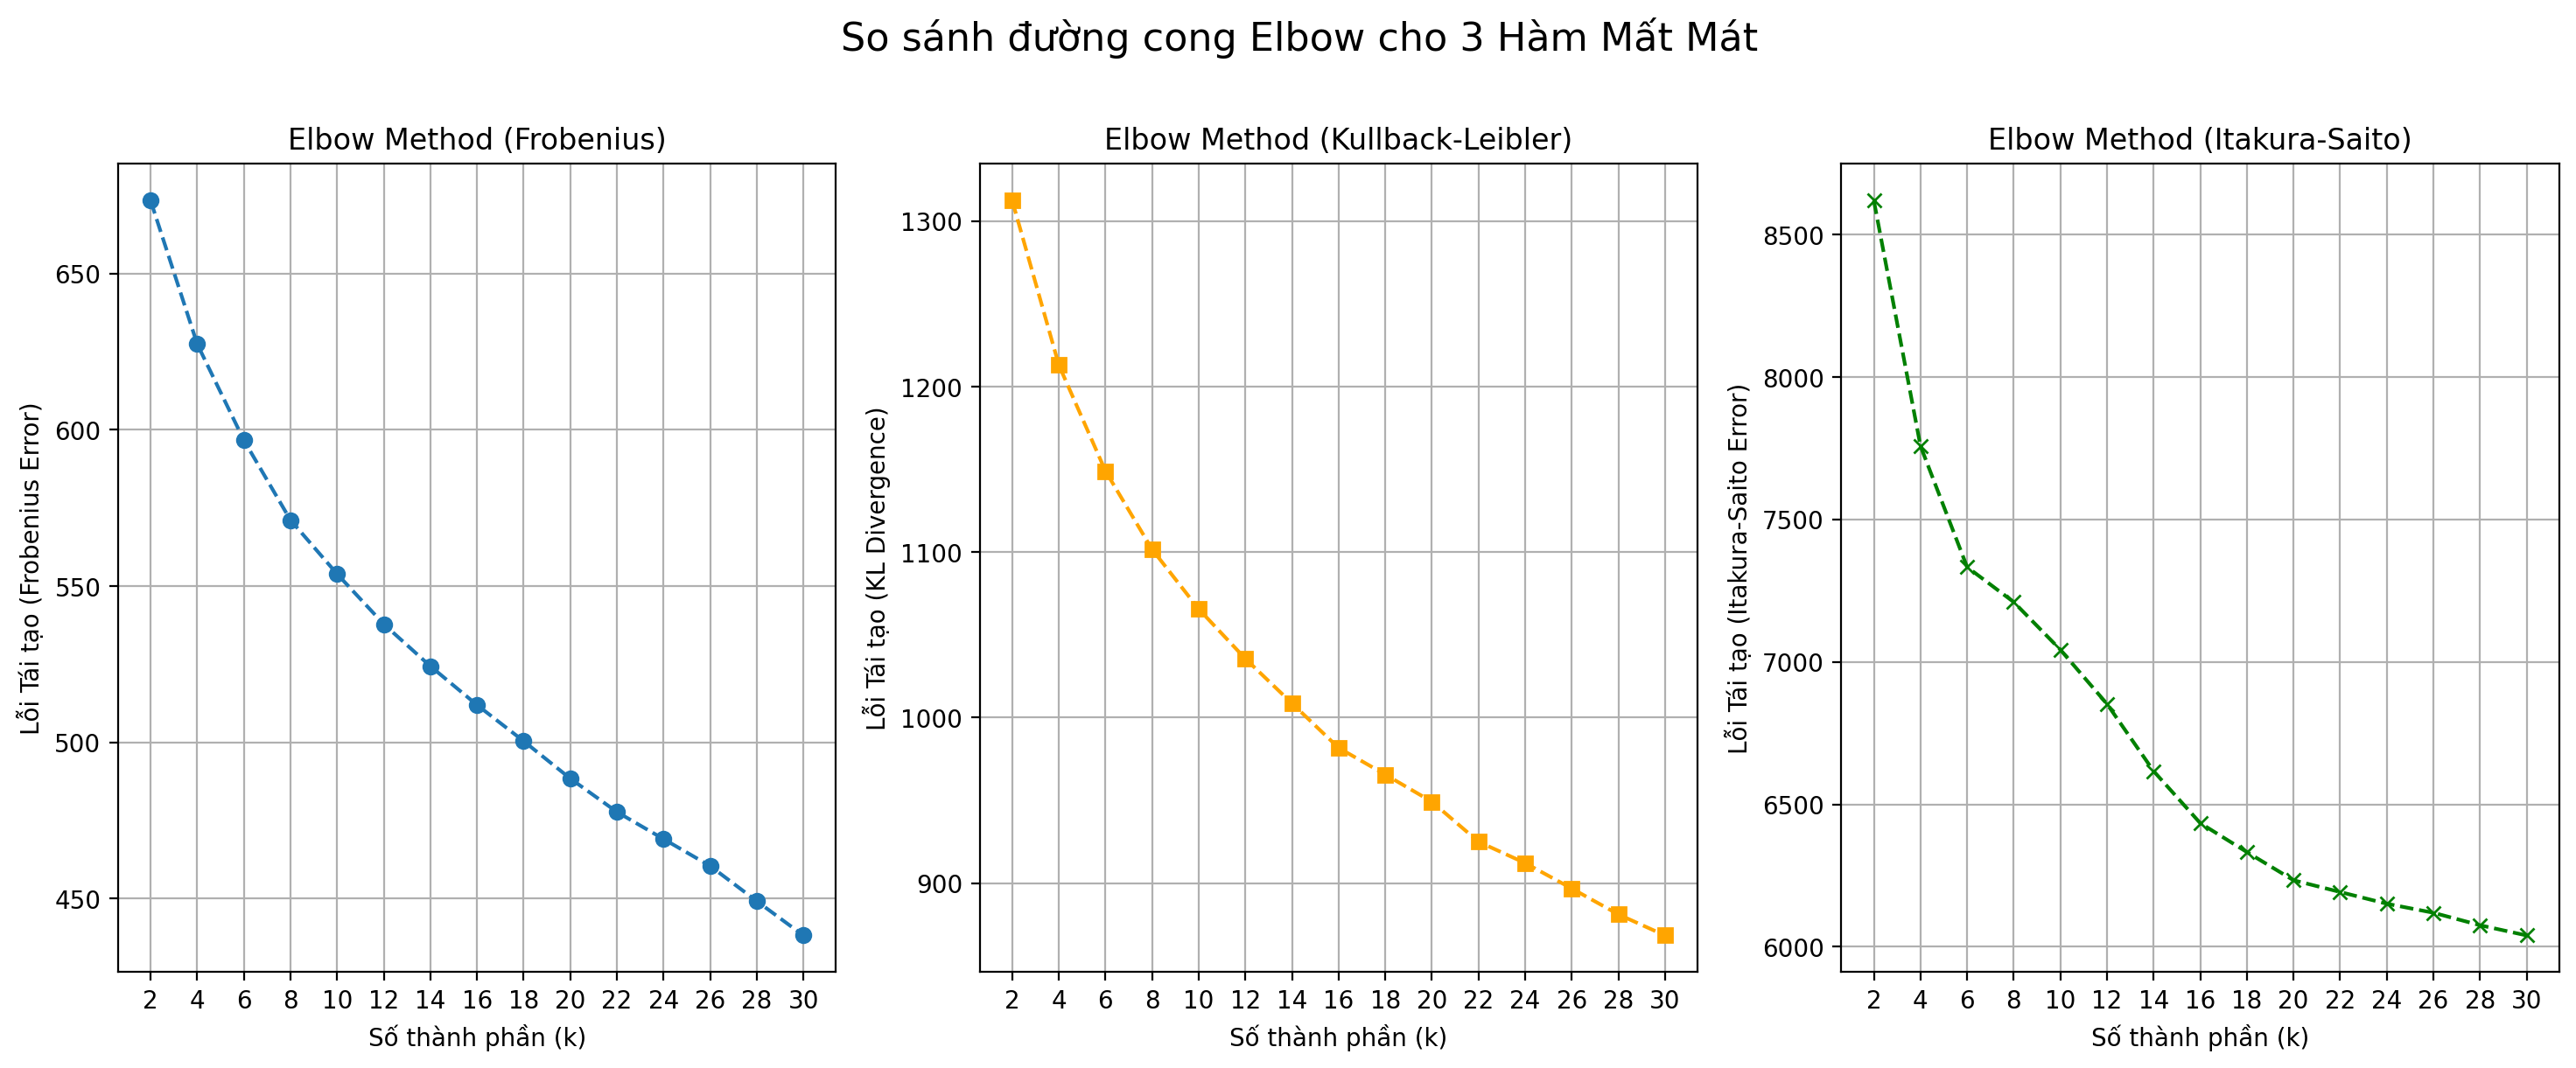

In [ ]:
# --- Vẽ 3 đồ thị Elbow ---
plt.figure(figsize=(18, 6))

# Đồ thị cho Frobenius
plt.subplot(1, 3, 1)
plt.plot(k_values, errors_frob, marker='o', linestyle='--')
plt.xlabel("Số thành phần (k)")
plt.ylabel("Lỗi Tái tạo (Frobenius Error)")
plt.title("Elbow Method (Frobenius)")
plt.xticks(k_values)
plt.grid(True)

# Đồ thị cho KL Divergence
plt.subplot(1, 3, 2)
plt.plot(k_values, errors_kl, marker='s', linestyle='--', color='orange')
plt.xlabel("Số thành phần (k)")
plt.ylabel("Lỗi Tái tạo (KL Divergence)")
plt.title("Elbow Method (Kullback-Leibler)")
plt.xticks(k_values)
plt.grid(True)

# Đồ thị cho Itakura-Saito
plt.subplot(1, 3, 3)
plt.plot(k_values, errors_is, marker='x', linestyle='--', color='green')
plt.xlabel("Số thành phần (k)")
plt.ylabel("Lỗi Tái tạo (Itakura-Saito Error)")
plt.title("Elbow Method (Itakura-Saito)")
plt.xticks(k_values)
plt.grid(True)

plt.suptitle("So sánh đường cong Elbow cho 3 Hàm Mất Mát", fontsize=16, y=1.02)
plt.show()

#### 6.6.3 Phân tích kết quả và chọn siêu tham số `k`

Đây là một bước phân tích rất quan trọng. Các biểu đồ này thể hiện mối quan hệ giữa **độ phức tạp của mô hình (Số thành phần `k` - trục X)** và **Lỗi Tái tạo (trục Y)**.

Mục tiêu của chúng ta là tìm điểm "khuỷu tay" (elbow) — điểm mà sau đó, việc tăng `k` (tăng độ phức tạp) không còn mang lại lợi ích đáng kể trong việc giảm lỗi.

1.  **Đồ thị Frobenius (Trái):**
    * Cho thấy lỗi giảm rất nhanh từ `k=2` đến `k=10`.
    * Từ `k=10` đến `k=14`, lỗi vẫn giảm nhưng chậm hơn.
    * Sau `k=14`, đường cong gần như đi ngang.
    * Điểm khuỷu tay (Elbow) rõ ràng nằm trong khoảng `k` = 10 đến 14.

2.  **Đồ thị Kullback-Leibler (Giữa):**
    * Tương tự, lỗi giảm mạnh mẽ nhất cho đến `k=10`.
    * Đường cong tiếp tục thoải dần cho đến `k=16` hoặc `k=18`.
    * Sau `k=18`, đường cong gần như phẳng.
    * Điểm khuỷu tay (Elbow) nằm trong khoảng `k` = 14 đến 18.

3.  **Đồ thị Itakura-Saito (Phải):**
    * Đường cong này "mượt" hơn nhiều và không có điểm "gãy" rõ rệt như hai đồ thị kia.
    * Lỗi giảm đều đặn và bắt đầu phẳng ra muộn hơn, sau `k` = 20.
    * Điều này củng cố thêm nhận định rằng IS không phải là hàm loss lý tưởng để tìm ra cấu trúc (components) rõ ràng cho dữ liệu ảnh MNIST.

---
### Nhận xét và Lựa chọn `k`

+ Dựa trên phân tích trên, không có một con số "hoàn hảo" duy nhất, mà chúng ta tìm thấy một **vùng tối ưu (optimal region)** cho các hàm loss hiệu quả (Frobenius và KL) nằm đâu đó trong khoảng **k = 12 đến 18**.

+ **Nhận xét:** Phân tích Elbow này đã **xác thực (validate)** rằng lựa chọn `k=16` mà chúng ta sẽ sử dụng cho các thực nghiệm so sánh bên dưới là một lựa chọn **rất tốt và hợp lý**, vì nó nằm ngay chính giữa vùng "khuỷu tay" tối ưu.

+ **Về phương pháp luận:** Mục tiêu chính của đồ án này là **so sánh bản chất của 3 hàm mất mát**. Để thực hiện một so sánh công bằng (apples-to-apples), chúng ta phải **cố định các siêu tham số khác**, bao gồm cả `k`. Do đó, chúng ta sẽ chọn một giá trị `k=16` duy nhất (đã được xác thực) để chạy cho cả ba mô hình trong thực nghiệm tiếp theo.

### 6.7 Hàm Huấn luyện Chính (Fit Function)

+ Bây giờ chúng ta tạo một hàm `nmf_from_scratch` chính, nhận vào $V$, $k$ và loại hàm mất mát (`loss_type`) để thực hiện vòng lặp cập nhật.

In [ ]:
def nmf_from_scratch(V, k, loss_type='frobenius', max_iter=200, tol=1e-4, random_state=42):
    """
    Hàm NMF chính, thực hiện vòng lặp cập nhật.
    """
    import time # Thêm dòng này để import module time
    print(f"Bắt đầu huấn luyện NMF (Từ gốc) với loss='{loss_type}', k={k}...")
    start_time = time.time()

    # 1. Chọn hàm cập nhật và hàm loss
    if loss_type == 'frobenius':
        update_func = update_frobenius
        loss_func = frobenius_loss
        V_fit = V # Frobenius có thể xử lý giá trị 0
    elif loss_type == 'kullback-leibler':
        update_func = update_kl
        loss_func = kl_divergence_loss
        V_fit = V + 1e-9 # Thêm epsilon rất nhỏ để tránh log(0)
    elif loss_type == 'itakura-saito':
        update_func = update_is
        loss_func = is_divergence_loss
        if np.min(V) == 0:
            print("  Cảnh báo: IS loss yêu cầu V > 0. Đã thêm epsilon = 1e-6.")
            V_fit = V + 1e-6 # IS yêu cầu V > 0
        else:
            V_fit = V
    else:
        raise ValueError(f"Loss type '{loss_type}' không được hỗ trợ.")

    # 2. Khởi tạo
    W, H = initialize_wh(V_fit, k, random_state)

    reconstruction_err = []

    # 3. Vòng lặp cập nhật
    for i in range(max_iter):
        W_old, H_old = np.copy(W), np.copy(H)

        # Cập nhật W và H
        W, H = update_func(V_fit, W, H)

        # Tính loss (10 vòng lặp 1 lần để tăng tốc)
        if i % 10 == 0:
            err = loss_func(V_fit, W, H)
            reconstruction_err.append(err)

            # 4. Kiểm tra hội tụ
            if i > 10 and (np.abs(reconstruction_err[-2] - err) < tol):
                print(f"Hội tụ ở vòng lặp {i+1}.")
                break

    print(f"Huấn luyện hoàn tất sau {time.time() - start_time:.2f} giây.")

    # Tính loss cuối cùng
    final_loss = loss_func(V_fit, W, H)
    reconstruction_err.append(final_loss)
    print(f"Lỗi tái tạo cuối cùng ({loss_type}): {final_loss:.4f}")

    return W, H, reconstruction_err

### 6.8 Tiến hành chạy thực nghiệm (From Scratch)
+ Chúng ta sẽ chạy NMF với $k=16$ đã được xác thực bằng phương pháp Elbow trên một tập con của $V$ (3000 mẫu) để tăng tốc độ minh họa thuật toán tự triển khai.

#### 6.8.1 Chạy thuật toán NMF (From Scratch) - Frobenius

##### 6.8.1.1 Tiến hành huấn luyện:

In [ ]:
k = 16 # Số thành phần
V_subset = V[:3000] # Lấy 3000 mẫu để huấn luyện, V là (samples, features)

W_frob_s, H_frob_s, err_frob_s = nmf_from_scratch(
    V_subset,
    k=k,
    loss_type='frobenius',
    max_iter=300,
    random_state=42
)

Bắt đầu huấn luyện NMF (Từ gốc) với loss='frobenius', k=16...
Huấn luyện hoàn tất sau 9.55 giây.
Lỗi tái tạo cuối cùng (frobenius): 38615.8804


##### 6.8.1.2 Trực quan hóa ma trận chứa các "ảnh cơ sở" (basis images):
+ Đây chính là các nét chữ mà mô hình học được

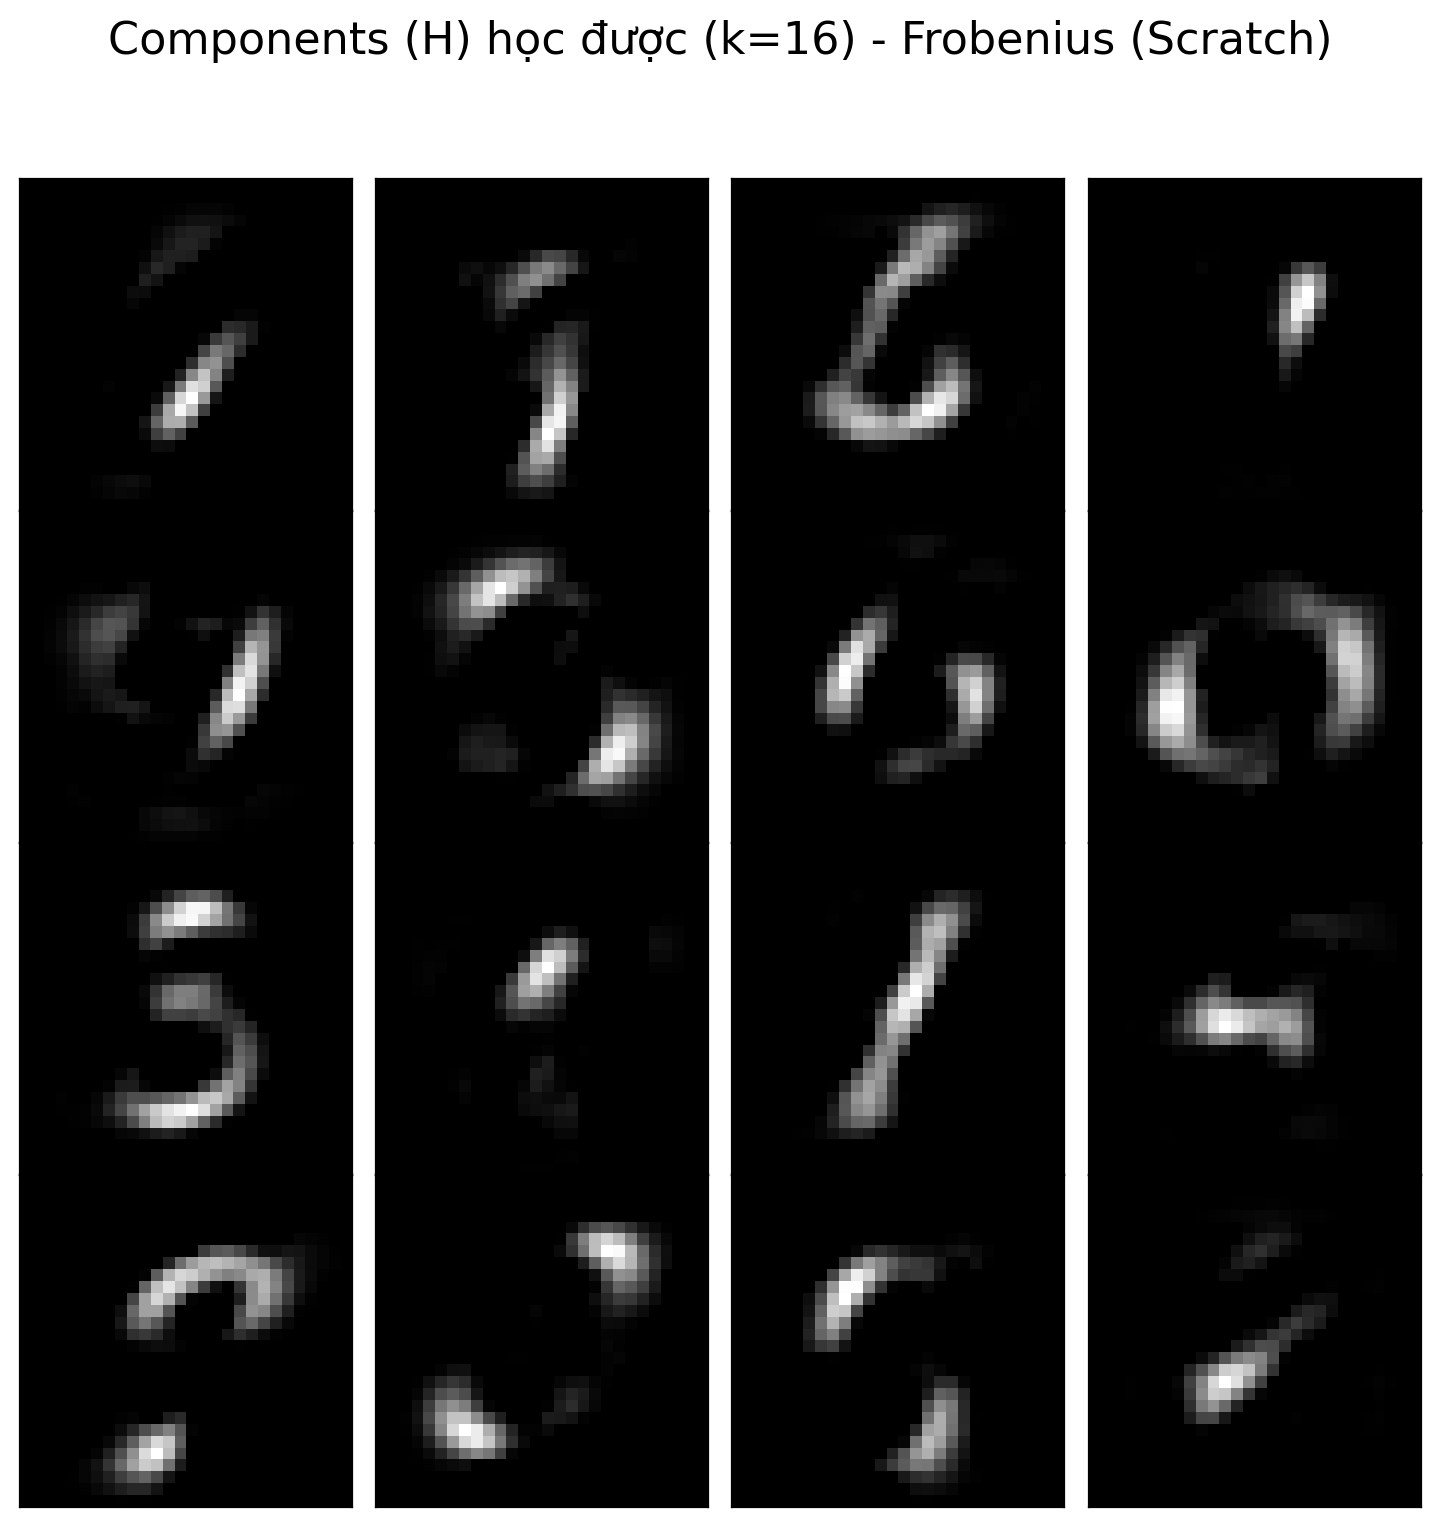

In [ ]:
# Trực quan hóa Components (H) - Frobenius (Scratch)
# H (k x n_features) -> (16 x 784). Các cơ sở (ảnh) nằm ở H.

plot_gallery(f"Components (H) học được (k={k}) - Frobenius (Scratch)",
             H_frob_s, # H chứa các cơ sở ảnh, mỗi hàng là một cơ sở
             image_shape,
             n_col=4,
             n_row=4)
plt.show()

#### 6.8.2 Chạy thuật toán NMF (From Scratch) - Kullback-Leibler

##### 6.8.2.1 Tiến hành huấn luyện:

In [ ]:
W_kl_s, H_kl_s, err_kl_s = nmf_from_scratch(
    V_subset,
    k=k,
    loss_type='kullback-leibler',
    max_iter=300,
    random_state=42
)

Bắt đầu huấn luyện NMF (Từ gốc) với loss='kullback-leibler', k=16...
Huấn luyện hoàn tất sau 20.19 giây.
Lỗi tái tạo cuối cùng (kullback-leibler): 143002.5199


##### 6.8.2.2 Trực quan hóa ma trận chứa các "ảnh cơ sở" (basis images):
+ Đây chính là các nét chữ mà mô hình học được

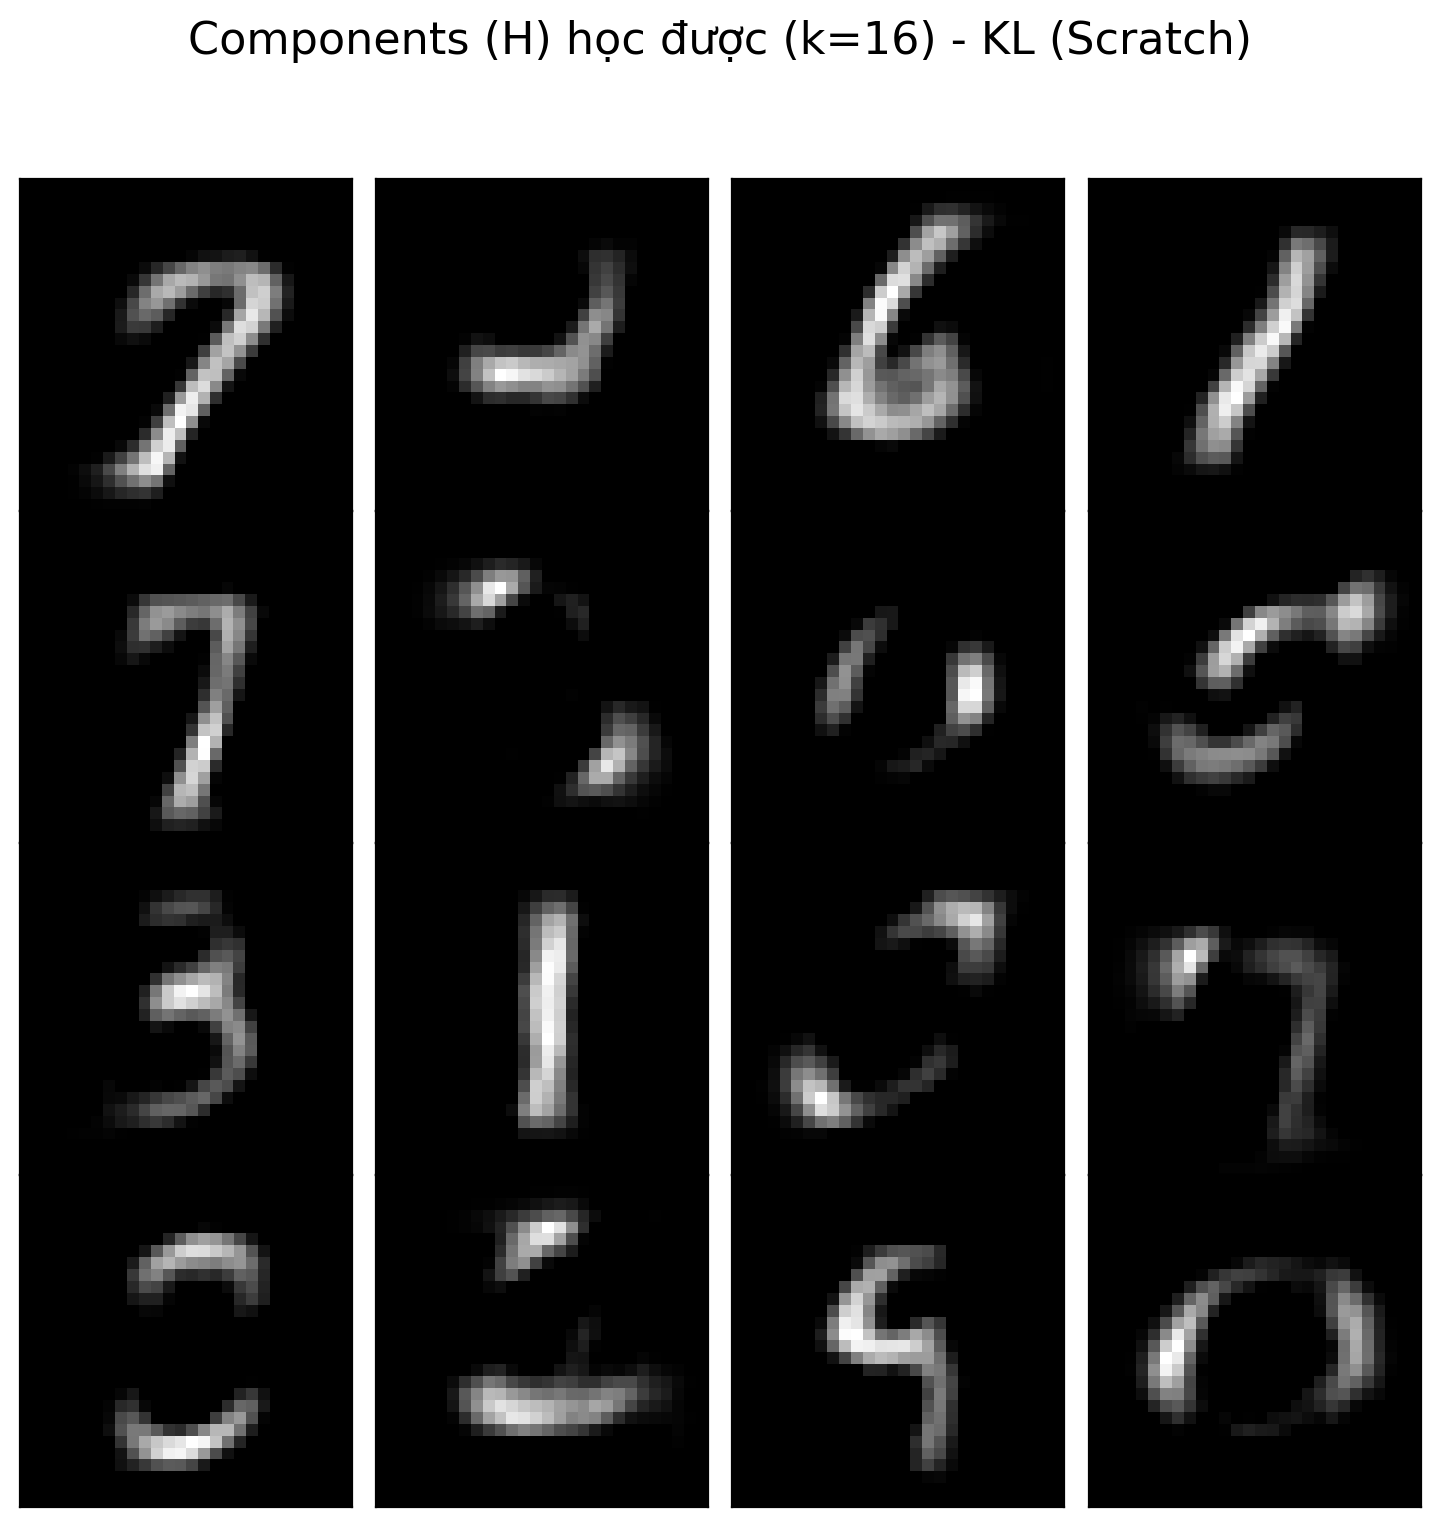

In [ ]:
# Trực quan hóa Components (H) - KL (Scratch)
plot_gallery(f"Components (H) học được (k={k}) - KL (Scratch)",
             H_kl_s,
             image_shape,
             n_col=4,
             n_row=4)
plt.show()

#### 6.8.3 Chạy thuật toán NMF (From Scratch) - Itakura-Saito

##### 6.8.3.1 Tiến hành huấn luyện:

In [ ]:
# IS yêu cầu V > 0
V_subset_is = V_subset + 1e-6

W_is_s, H_is_s, err_is_s = nmf_from_scratch(
    V_subset_is,
    k=k,
    loss_type='itakura-saito',
    max_iter=300,
    random_state=42
)

Bắt đầu huấn luyện NMF (Từ gốc) với loss='itakura-saito', k=16...
Huấn luyện hoàn tất sau 40.01 giây.
Lỗi tái tạo cuối cùng (itakura-saito): 6340955.7984


##### 6.8.3.2 Trực quan hóa ma trận chứa các "ảnh cơ sở" (basis images):
+ Đây chính là các nét chữ mà mô hình học được

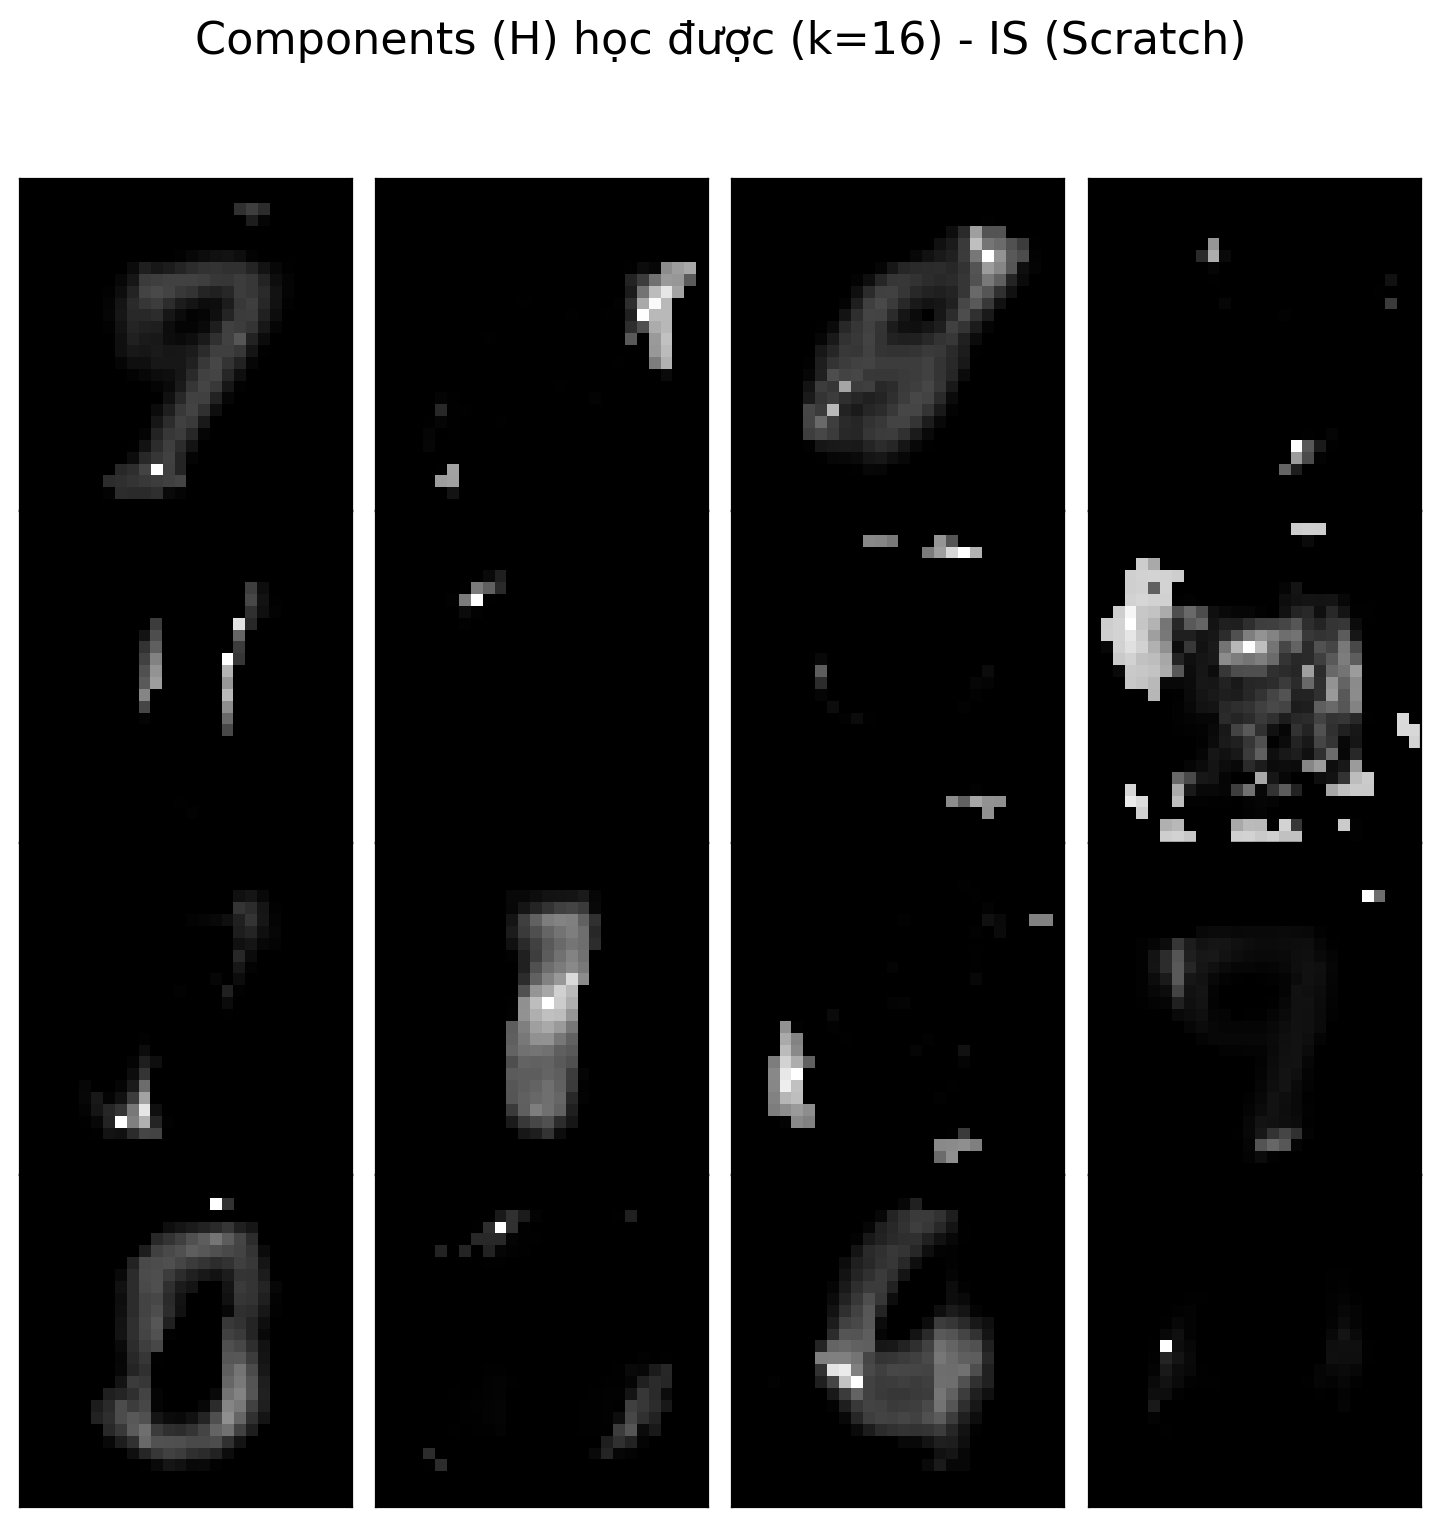

In [ ]:
# Trực quan hóa Components (H) - IS (Scratch)
plot_gallery(f"Components (H) học được (k={k}) - IS (Scratch)",
             H_is_s,
             image_shape,
             n_col=4,
             n_row=4)
plt.show()

### 6.9 Trực quan hóa sự hội tụ của các Hàm Mất mát (Loss Function)
+ Biểu đồ này trực quan hóa giá trị hàm mục tiêu (Cost) được ghi lại ở mỗi vòng lặp, cho phép so sánh tốc độ và sự ổn định hội tụ của các hàm mất mát khác nhau.

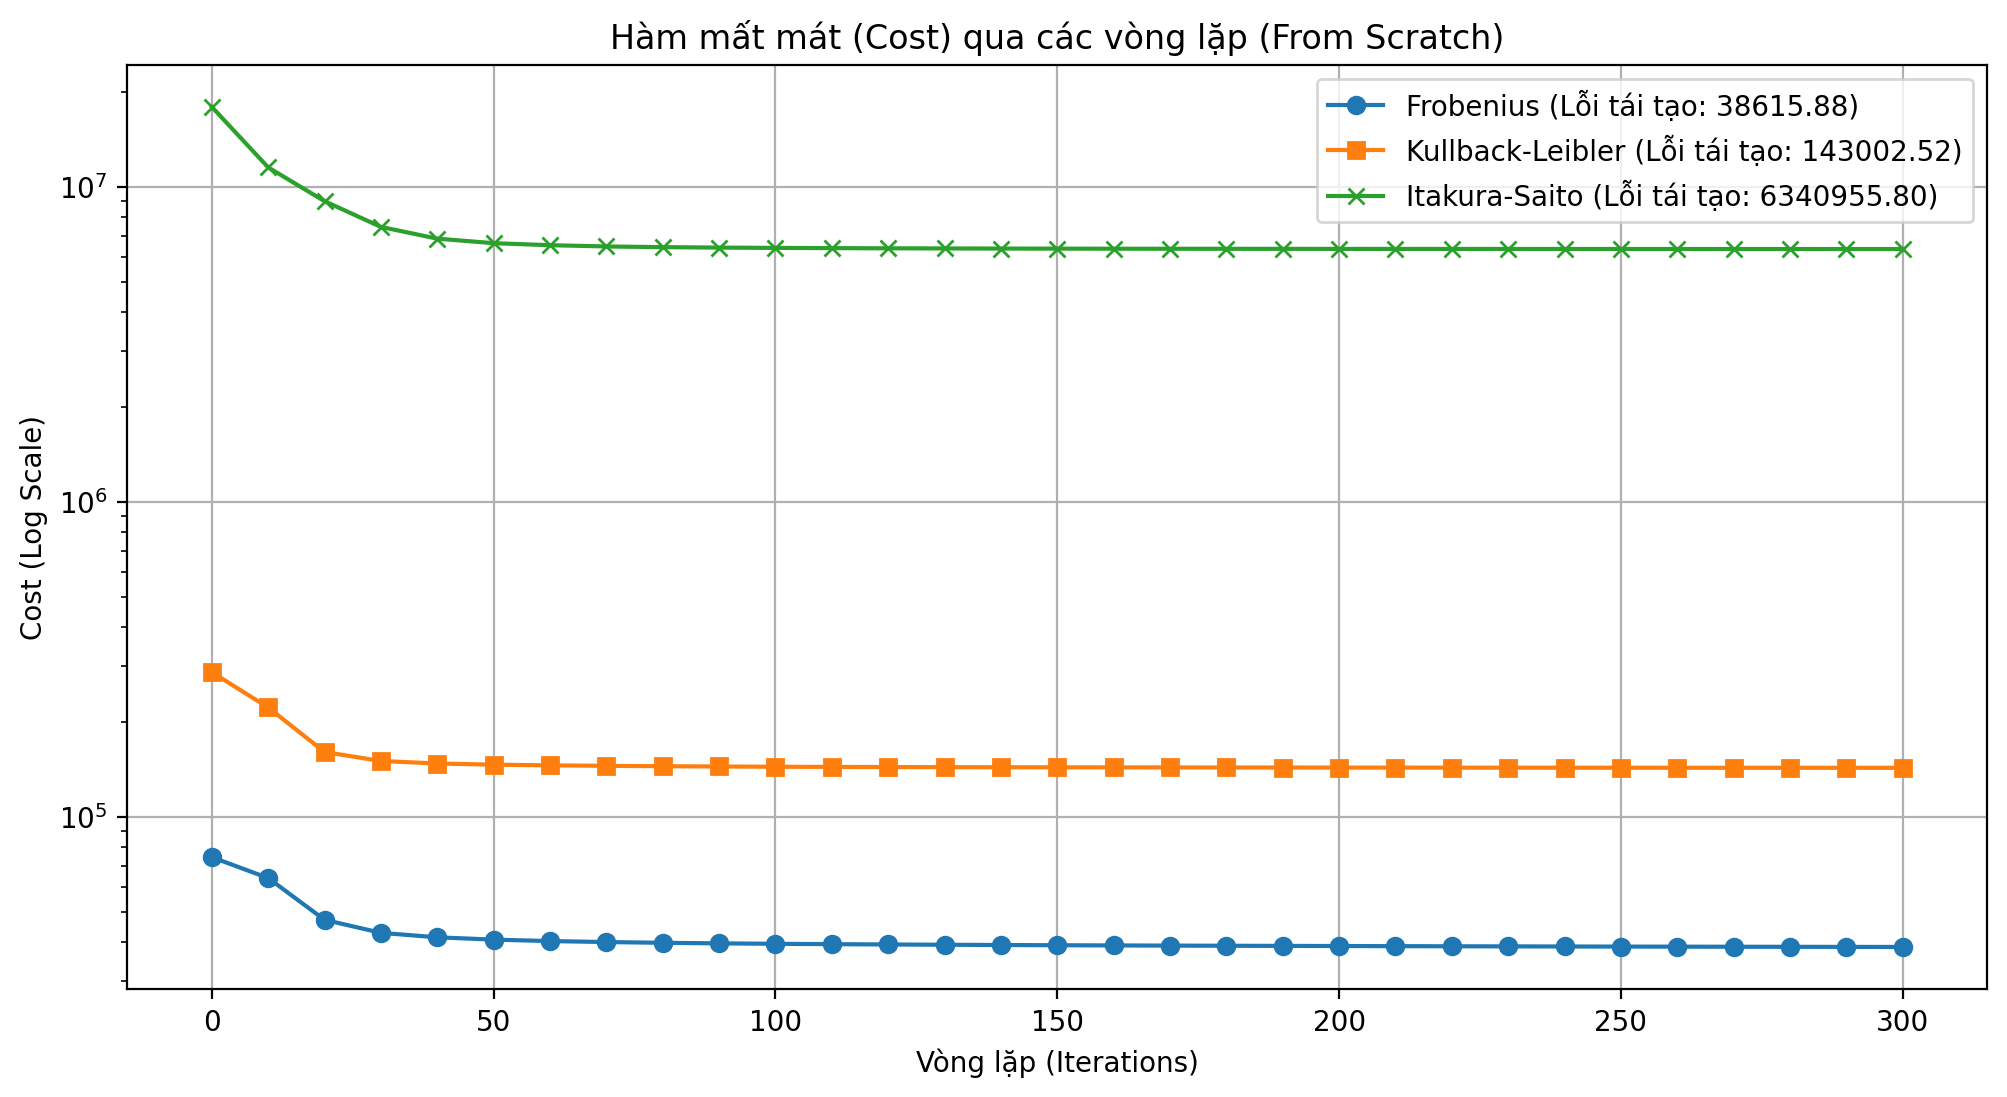

In [ ]:
plt.figure(figsize=(12, 6))

# Lấy số vòng lặp thực tế (đã nhân 10)
iters_frob = np.arange(len(err_frob_s)) * 10
iters_kl = np.arange(len(err_kl_s)) * 10
iters_is = np.arange(len(err_is_s)) * 10

# Vẽ đồ thị
plt.plot(iters_frob, err_frob_s, label=f"Frobenius (Lỗi tái tạo: {err_frob_s[-1]:.2f})", marker='o')
plt.plot(iters_kl, err_kl_s, label=f"Kullback-Leibler (Lỗi tái tạo: {err_kl_s[-1]:.2f})", marker='s')
plt.plot(iters_is, err_is_s, label=f"Itakura-Saito (Lỗi tái tạo: {err_is_s[-1]:.2f})", marker='x')

plt.title("Hàm mất mát (Cost) qua các vòng lặp (From Scratch)")
plt.xlabel("Vòng lặp (Iterations)")
plt.ylabel("Cost (Log Scale)")
plt.legend()
plt.yscale('log') # Dùng thang log vì các hàm loss có giá trị rất khác nhau
plt.grid(True)
plt.show()

### 6.10. Phân tích (Thực nghiệm 1 - From Scratch)

* **Hội tụ:** Cả ba thuật toán cập nhật nhân (MUR) đều hội tụ, thể hiện qua việc hàm mất mát (Cost) giảm dần qua các vòng lặp.
* **Trực quan (Components):**
    * **Frobenius:** Có xu hướng tạo ra các thành phần mờ, bao phủ nhiều vùng (giống nhiễu Gaussian).
    * **KL Divergence:** Tạo ra các thành phần "thưa" (sparse) và sắc nét hơn, giống các nét (strokes) hoặc bộ phận riêng lẻ của chữ số (ví dụ: vòng tròn của số 0, nét gạch của số 1).
    * **Itakura-Saito:** Tạo ra các thành phần nhiễu, không có cấu trúc rõ ràng.
* **Kết luận (From Scratch):** Tương tự như lý thuyết, KL-Divergence cho thấy khả năng trích xuất "bộ phận" (parts-based) tốt nhất cho dữ liệu ảnh MNIST.

## 7. Thực nghiệm 2: So sánh với thư viện Scikit-learn `sklearn.decomposition.NMF`

✍️ Giới thiệu Thực nghiệm 2:
+ Sau khi đã tự triển khai và hiểu rõ cơ chế cập nhật "from scratch" trên một tập dữ liệu con (3.000 mẫu) ở Mục 6, thực nghiệm thứ hai này sẽ chuyển sang sử dụng thư viện sklearn.decomposition.NMF đã được tối ưu hóa.
+ Mục tiêu của thực nghiệm này là:
  + Mở rộng quy mô (Scale): Thực nghiệm này sẽ được tiến hành trên toàn bộ 10.000 mẫu của ma trận $V$, cho phép chúng ta so sánh (benchmark) hiệu suất và kết quả trích xuất đặc trưng của các hàm mất mát trên quy mô lớn hơn.

  + Xác thực (Validation): So sánh và xác thực lại những quan sát về các "ảnh cơ sở" (components) được trích xuất bởi cả ba hàm mất mát (Frobenius, KL, và IS) khi sử dụng một thư viện tiêu chuẩn đã được tối ưu hóa.

### 7.1 Triển khai thuật toán NMF - Frobenius bằng thư viện Sklearn:

Huấn luyện Sklearn NMF (Frobenius) trên V (10000, 784)...
Lỗi tái tạo (Frobenius): 511.9520


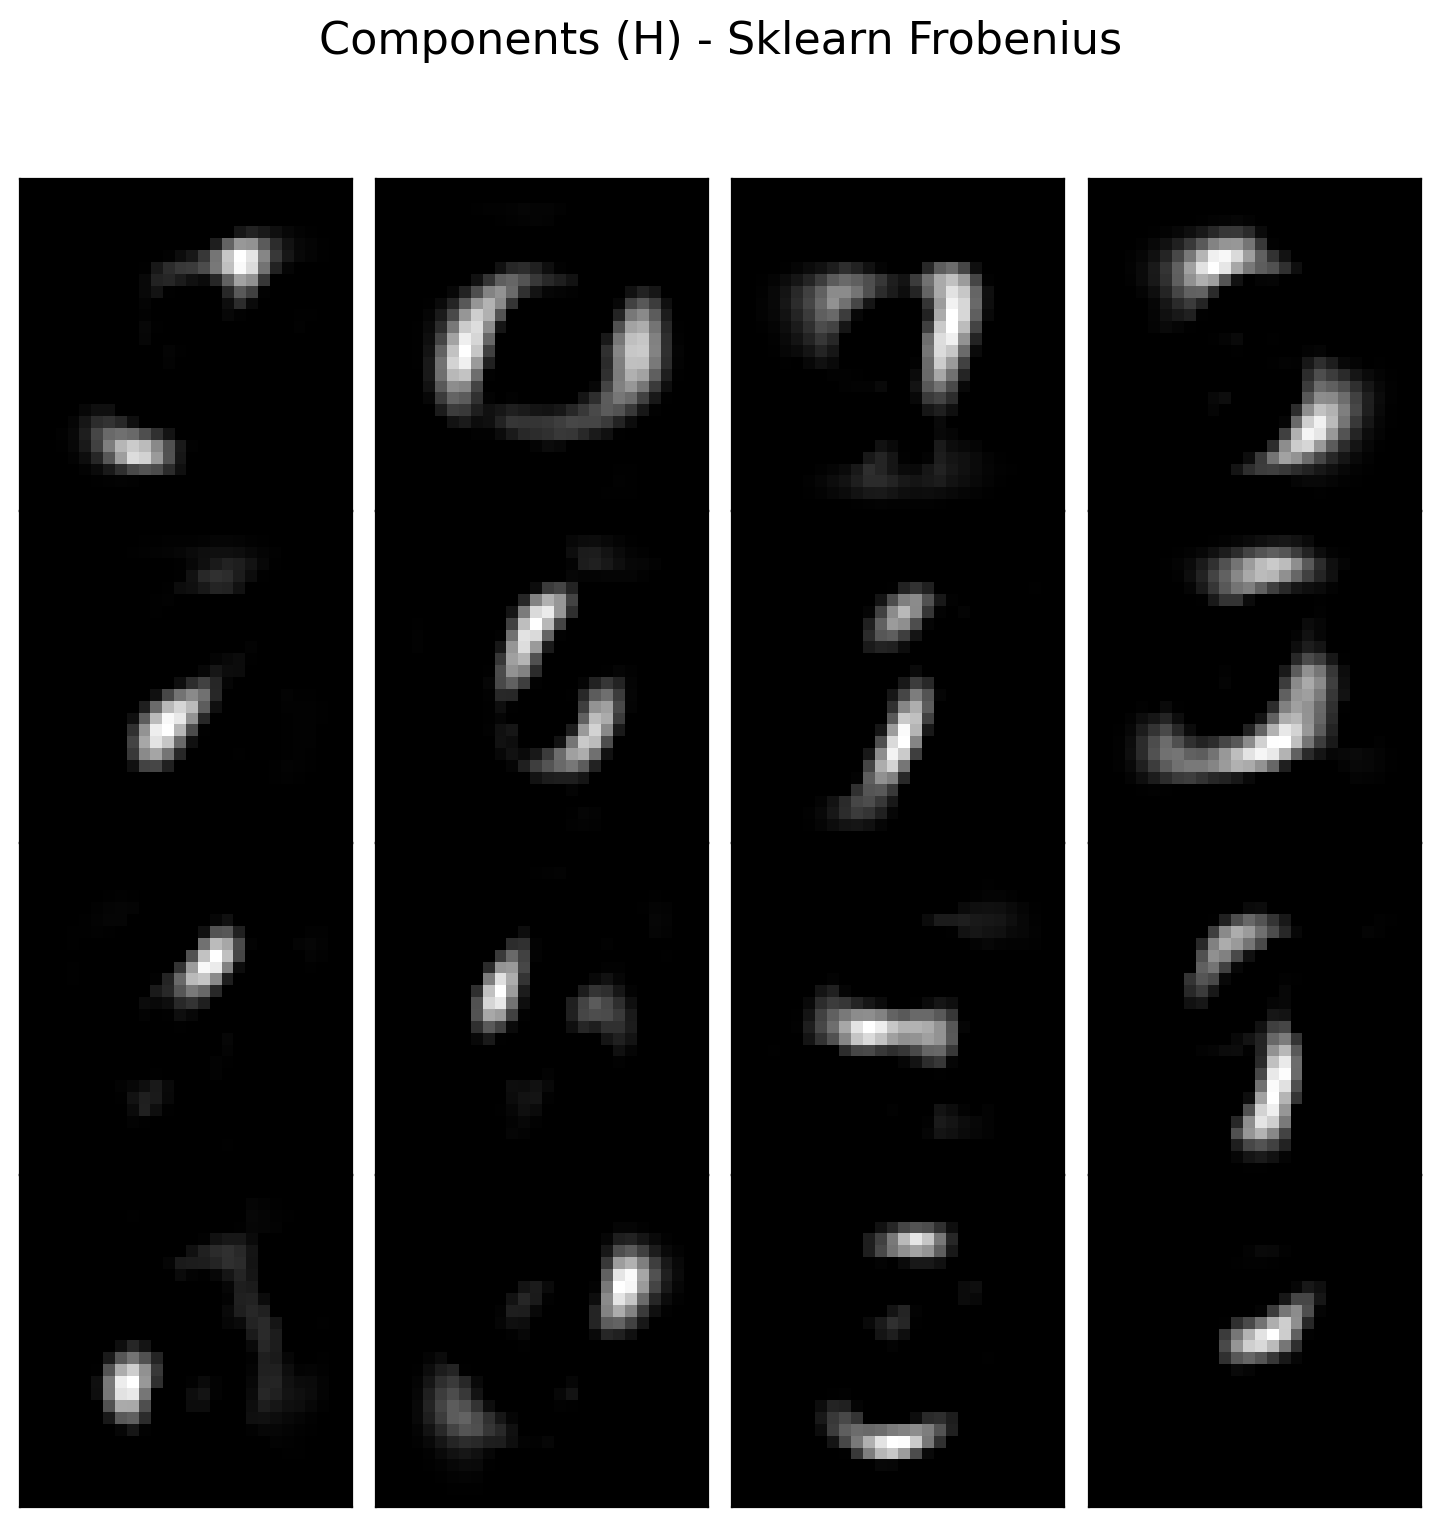

In [ ]:
print(f"Huấn luyện Sklearn NMF (Frobenius) trên V {V.shape}...")
nmf_frob_sk = SklearnNMF(
    n_components=k,
    beta_loss='frobenius', # Frobenius
    solver='mu',           # Multiplicative Update
    init='nndsvda',        # Phương pháp khởi tạo tốt
    max_iter=500,
    random_state=42
)
W_frob_sk = nmf_frob_sk.fit_transform(V) # Sklearn nhận (samples, features) -> V.T
H_frob_sk = nmf_frob_sk.components_

print(f"Lỗi tái tạo (Frobenius): {nmf_frob_sk.reconstruction_err_:.4f}")

# Components của Sklearn nằm trong .components_ (H)
# Nhưng vì V đầu vào của Sklearn là (samples, features), nên W của Sklearn tương ứng với H của chúng ta
# V_data (N, m) approx W_sk (N, k) * H_sk (k, m)
# V (m, N) approx W_scratch (m, k) * H_scratch (k, N)
# -> H_sk (k, m) chính là các ảnh cơ sở (784 features)
plot_gallery(f"Components (H) - Sklearn Frobenius", H_frob_sk, image_shape, n_col=4, n_row=4)
plt.show()

### 7.2 Triển khai thuật toán NMF - Kullback-Leibler bằng thư viện Sklearn:

Huấn luyện Sklearn NMF (KL) trên V (10000, 784)...
Lỗi tái tạo (KL): 981.7502


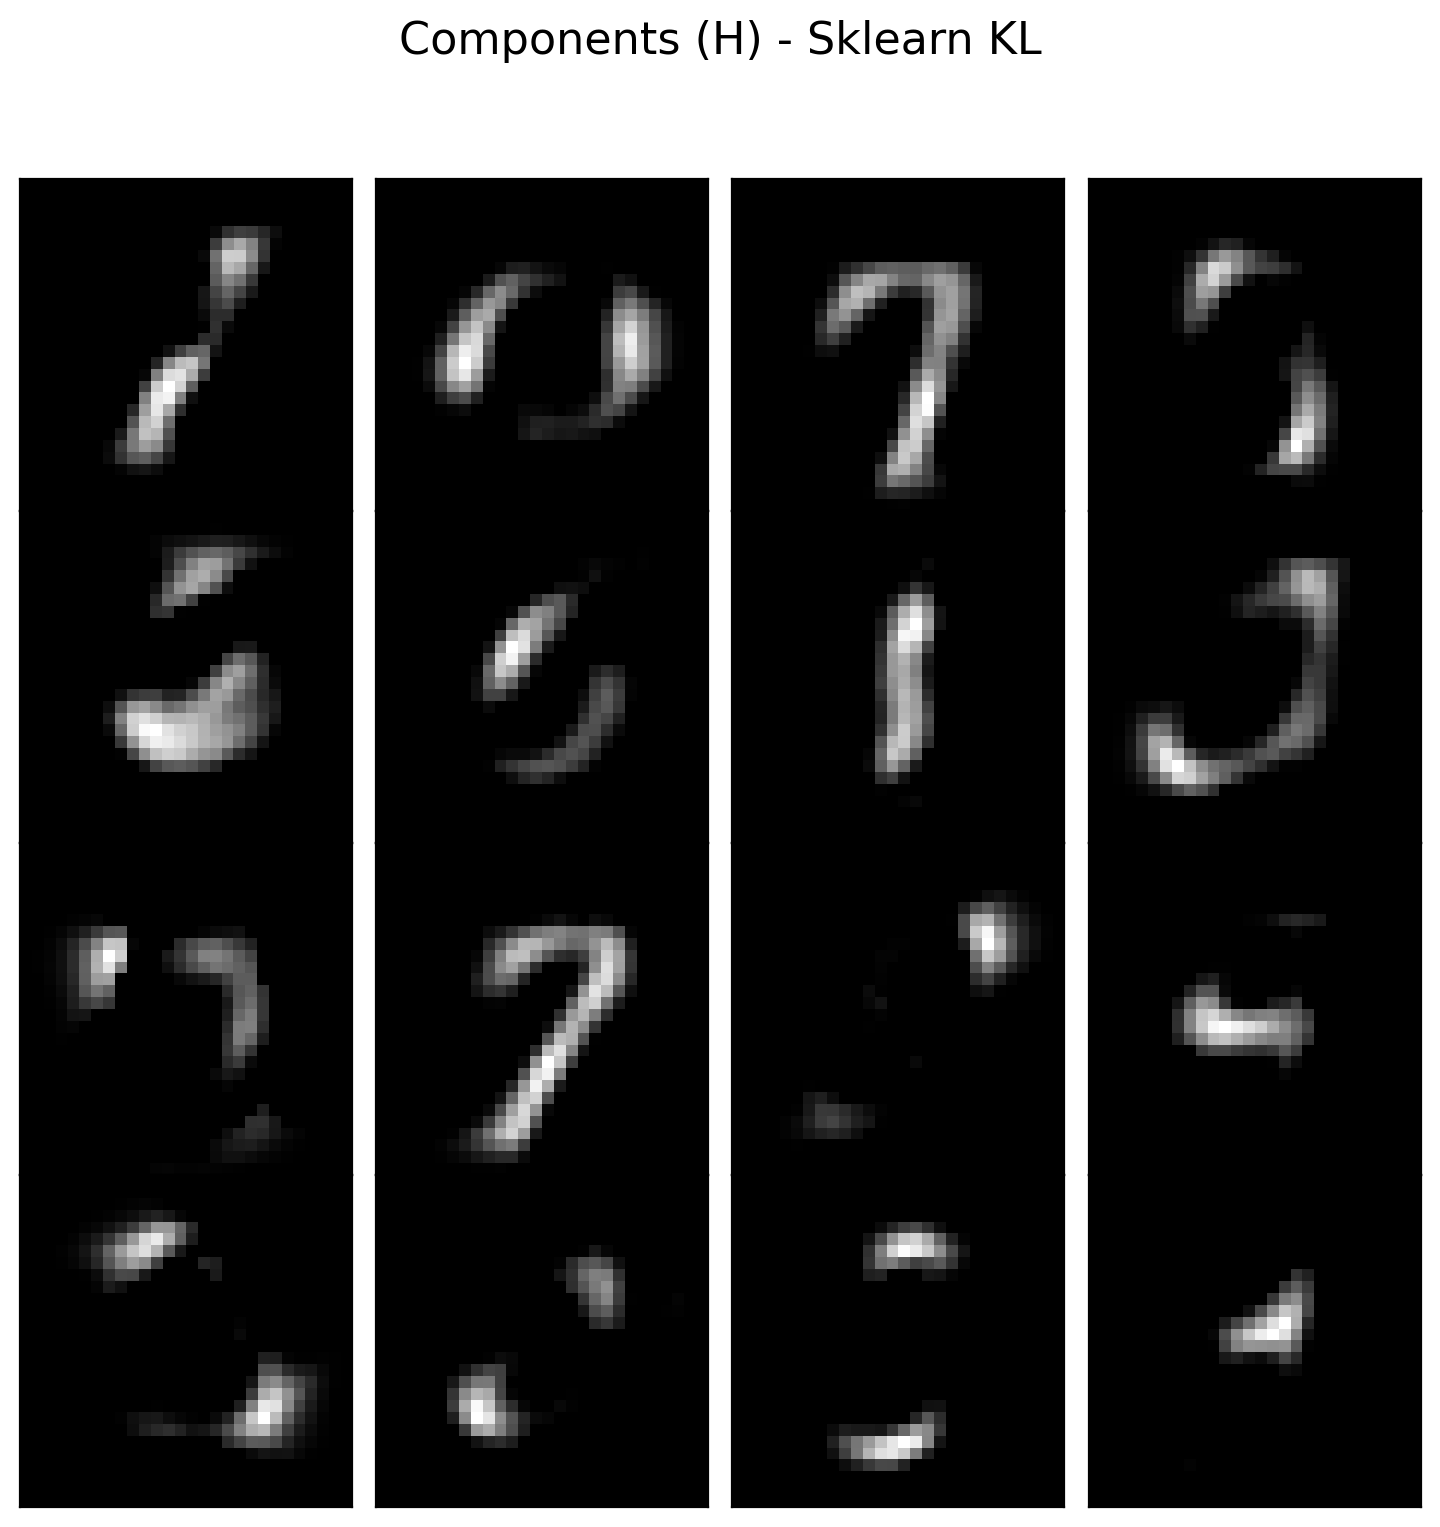

In [ ]:
print(f"Huấn luyện Sklearn NMF (KL) trên V {V.shape}...")
nmf_kl_sk = SklearnNMF(
    n_components=k,
    beta_loss='kullback-leibler', # KL
    solver='mu',
    init='nndsvda',
    max_iter=500,
    random_state=42,
    tol=1e-4 # Tăng tol để hội tụ nhanh hơn
)

# Thêm epsilon cho V (giống như 'from scratch')
W_kl_sk = nmf_kl_sk.fit_transform(V + 1e-9)
H_kl_sk = nmf_kl_sk.components_

print(f"Lỗi tái tạo (KL): {nmf_kl_sk.reconstruction_err_:.4f}")

plot_gallery(f"Components (H) - Sklearn KL", H_kl_sk, image_shape, n_col=4, n_row=4)
plt.show()

### 7.3 Triển khai thuật toán NMF - Itakura-Saito bằng thư viện Sklearn:

Huấn luyện Sklearn NMF (IS) trên V (10000, 784)...
Lỗi tái tạo (IS): 6433.8533


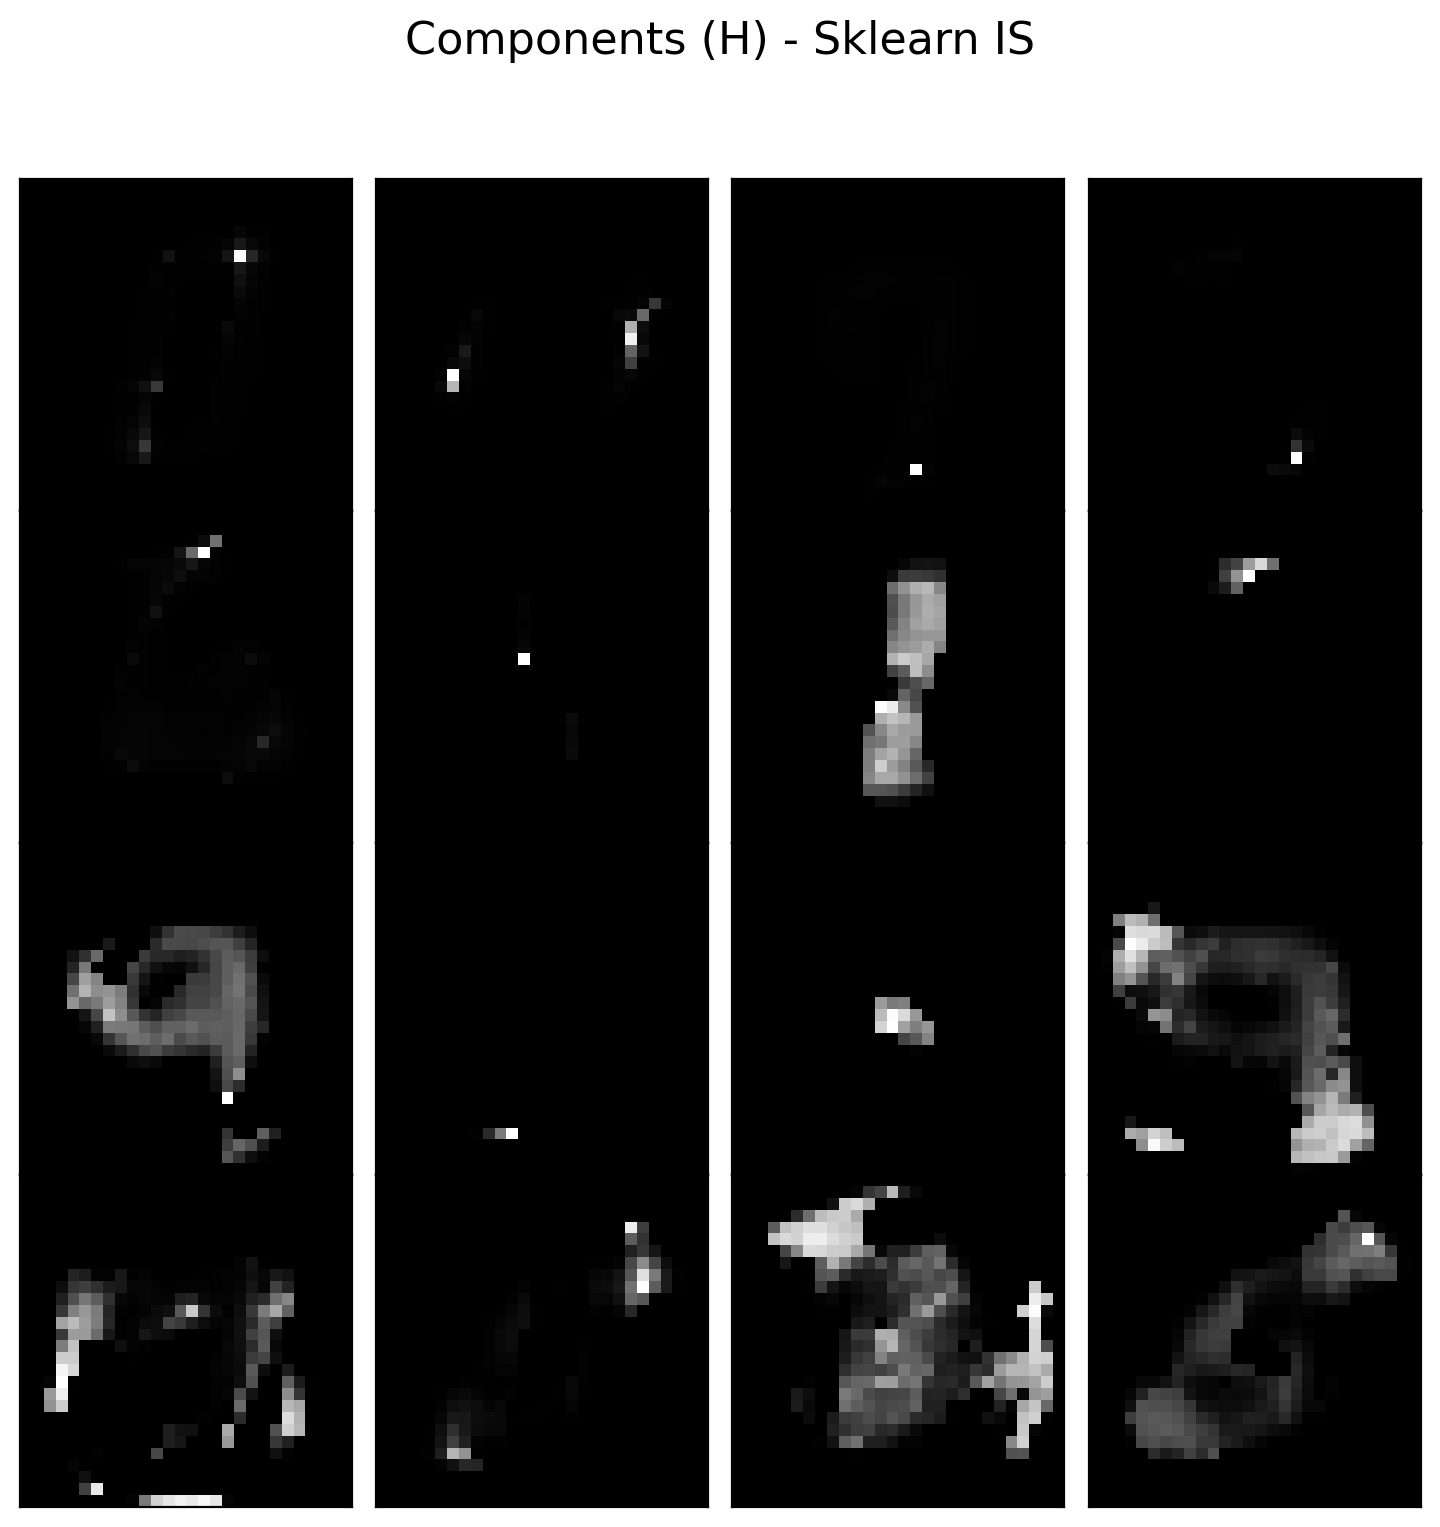

In [ ]:
print(f"Huấn luyện Sklearn NMF (IS) trên V {V.shape}...")
# IS Divergence không hoạt động nếu có giá trị 0 trong V.
V_is = V + 1e-6

nmf_is_sk = SklearnNMF(
    n_components=k,
    beta_loss='itakura-saito', # IS
    solver='mu',
    init='nndsvda',
    max_iter=500,
    random_state=42
)
W_is_sk = nmf_is_sk.fit_transform(V_is)
H_is_sk = nmf_is_sk.components_

print(f"Lỗi tái tạo (IS): {nmf_is_sk.reconstruction_err_:.4f}")

plot_gallery(f"Components (H) - Sklearn IS", H_is_sk, image_shape, n_col=4, n_row=4)
plt.show()

### 7.4 Phân tích (Thực nghiệm 2 - Sử dụng thư viện Sklearn)
Kết quả từ thư viện sklearn cho thấy sự khác biệt rõ rệt khi áp dụng các hàm mất mát khác nhau lên cùng một bộ dữ liệu MNIST:

+ Frobenius và KL: Tương tự như kết quả "From Scratch", các thành phần (components) học được từ KL Divergence (b) rõ nét hơn, có xu hướng "thưa" (sparse) và giống "bộ phận" (các nét chữ) hơn so với Frobenius Norm (a).

+ Itakura-Saito (IS): Quan sát thực tế cho thấy các thành phần (c) do IS tạo ra hoàn toàn không thể nhận diện được (trông như nhiễu). Điều này hoàn toàn phù hợp với lý thuyết:

  + IS nhạy cảm với sai số tỷ lệ (scale-invariant). Sai số tỉ lệ ở các vùng nền (vốn ít quan trọng) lại bị phạt nặng một cách không cần thiết, làm thuật toán không tập trung vào các nét chữ (foreground) mà bị phân tán vào việc mô hình hóa các vùng nền có giá trị nhỏ.

  + Nó được thiết kế tối ưu cho xử lý phổ âm thanh. Khi áp dụng vào dữ liệu ảnh như MNIST (vốn có rất nhiều pixel giá trị 0), thuật toán có thể tạo ra các thành phần cực kỳ nhiễu và không có cấu trúc hình ảnh rõ ràng.

+ So sánh Lỗi (Error):

  + Lỗi Frobenius (a): 511.9520

  + Lỗi KL (b): 981.7502

  + Lỗi IS (c): 6433.8533

+ Lưu ý:
  + Các giá trị lỗi này không thể so sánh trực tiếp với nhau để kết luận mô hình nào "tốt hơn", vì chúng là ba đơn vị đo lường khác nhau.

  + Lỗi Frobenius (511.95) là dễ diễn giải nhất vì nó về bản chất chính là Tổng bình phương sai số (tương tự MSE trong Linear Regression). Lỗi KL (981.75) là độ chênh lệch về phân phối, và lỗi IS (6433.85) là độ chênh lệch về tỷ lệ.

=> Kết luận: Dựa trên cả trực quan (components) và lý thuyết (bản chất dữ liệu), hàm mất mát Kullback-Leibler là phù hợp nhất để trích xuất đặc trưng (các nét chữ) cho bộ dữ liệu MNIST.

## 8. Thực nghiệm 3: So sánh khả năng Tái tạo ảnh (Reconstruction)
📸 Giới thiệu Thực nghiệm 3
+ Sau khi đã huấn luyện 3 mô hình NMF với sklearn ở Mục 7, chúng ta sẽ so sánh trực quan khả năng tái tạo ảnh gốc của chúng.
+ Chúng ta sẽ lấy một vài ảnh gốc từ ma trận $V$, sử dụng hàm .transform() của mỗi mô hình (Frobenius, KL, và IS) để tìm ma trận hệ số $W$ mới, sau đó tái tạo lại ảnh bằng cách nhân $W_{new} \times H_{learned}$.
+ Thí nghiệm này sẽ cho thấy rõ:  
  + Khả năng nén dữ liệu của NMF (từ 784 xuống còn 16 đặc trưng).
  + Hàm mất mát nào (Frobenius, KL, hay IS) giữ lại được nhiều thông tin trực quan nhất sau khi tái tạo. Dựa trên Mục 7, chúng ta kỳ vọng mô hình KL sẽ cho kết quả rõ nét nhất.
+ Chúng ta sẽ đánh giá kết quả thực nghiệm bằng 2 phương pháp:
  1.  **Phân tích Trực quan:** Lấy 10 ảnh mẫu và tái tạo chúng bằng cả 3 mô hình (Frobenius, KL, IS) để xem bằng mắt thường.
  2.  **Phân tích Định lượng:** Sử dụng các độ đo **MSE, MAE, và R2** để đánh giá mức độ chính xác của ảnh tái tạo so với ảnh gốc.

### 8.1 Tiến hành lấy 10 ảnh mẫu từ ma trận gốc $V$

In [ ]:
# Lấy 10 ảnh đầu tiên từ bộ V
V_sample = V[:10]

# Tạo mẫu V_sample_is (thêm epsilon) để dùng cho mô hình IS,
# vì model IS (nmf_is_sk) đã được huấn luyện trên dữ liệu không có số 0.
V_sample_is = V_sample + 1e-6

### 8.2 Thực hiện tái tạo ảnh bằng thuật toán NMF - Phân kỳ Frobenius

In [ ]:
# 1. Dùng model Frobenius (nmf_frob_sk) để tìm hệ số W_new (10, 16)
W_new_frob = nmf_frob_sk.transform(V_sample)

# 2. Tái tạo V_recon (10, 784) = W_new (10, 16) @ H_frob_sk (16, 784)
V_recon_frob = W_new_frob @ H_frob_sk

### 8.3 Thực hiện tái tạo ảnh bằng thuật toán NMF - Phân kỳ Kullback-Leibler

In [ ]:
# 1. Dùng model KL (nmf_kl_sk) để tìm hệ số W_new (10, 16)
W_new_kl = nmf_kl_sk.transform(V_sample)

# 2. Tái tạo V_recon (10, 784) = W_new (10, 16) @ H_kl_sk (16, 784)
V_recon_kl = W_new_kl @ H_kl_sk

### 8.4 Thực hiện tái tạo ảnh bằng thuật toán NMF - Phân kỳ Itakura-Saito

In [ ]:
# 1. Dùng model IS (nmf_is_sk) để tìm hệ số W_new (10, 16)
# Lưu ý: Phải dùng V_sample_is (đã cộng epsilon)
W_new_is = nmf_is_sk.transform(V_sample_is)

# 2. Tái tạo V_recon (10, 784) = W_new (10, 16) @ H_is_sk (16, 784)
V_recon_is = W_new_is @ H_is_sk

### 8.5. Trực quan hóa so sánh

#### 8.5.1 Ảnh gốc (Ma trận $V$):

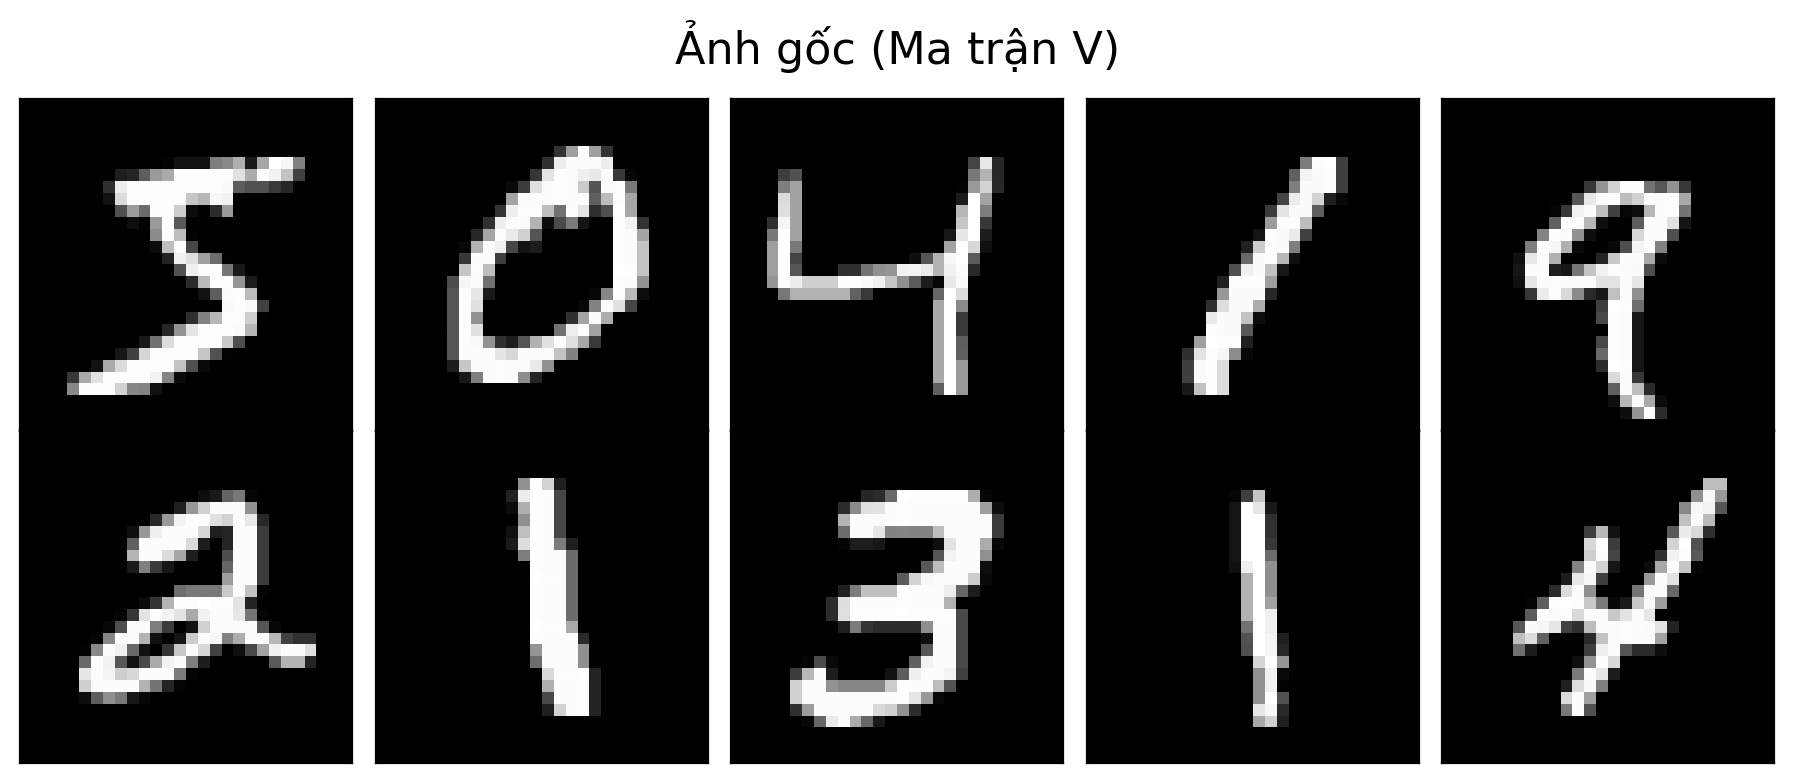

In [ ]:
# Sử dụng hàm plot_gallery đã định nghĩa ở Mục 5

# 1. Ảnh gốc
plot_gallery("Ảnh gốc (Ma trận V)", V_sample, image_shape, n_col=5, n_row=2)
plt.show()

#### 8.5.2 Ảnh sau khi tái tạo - Frobenius ($W$ x $H$)

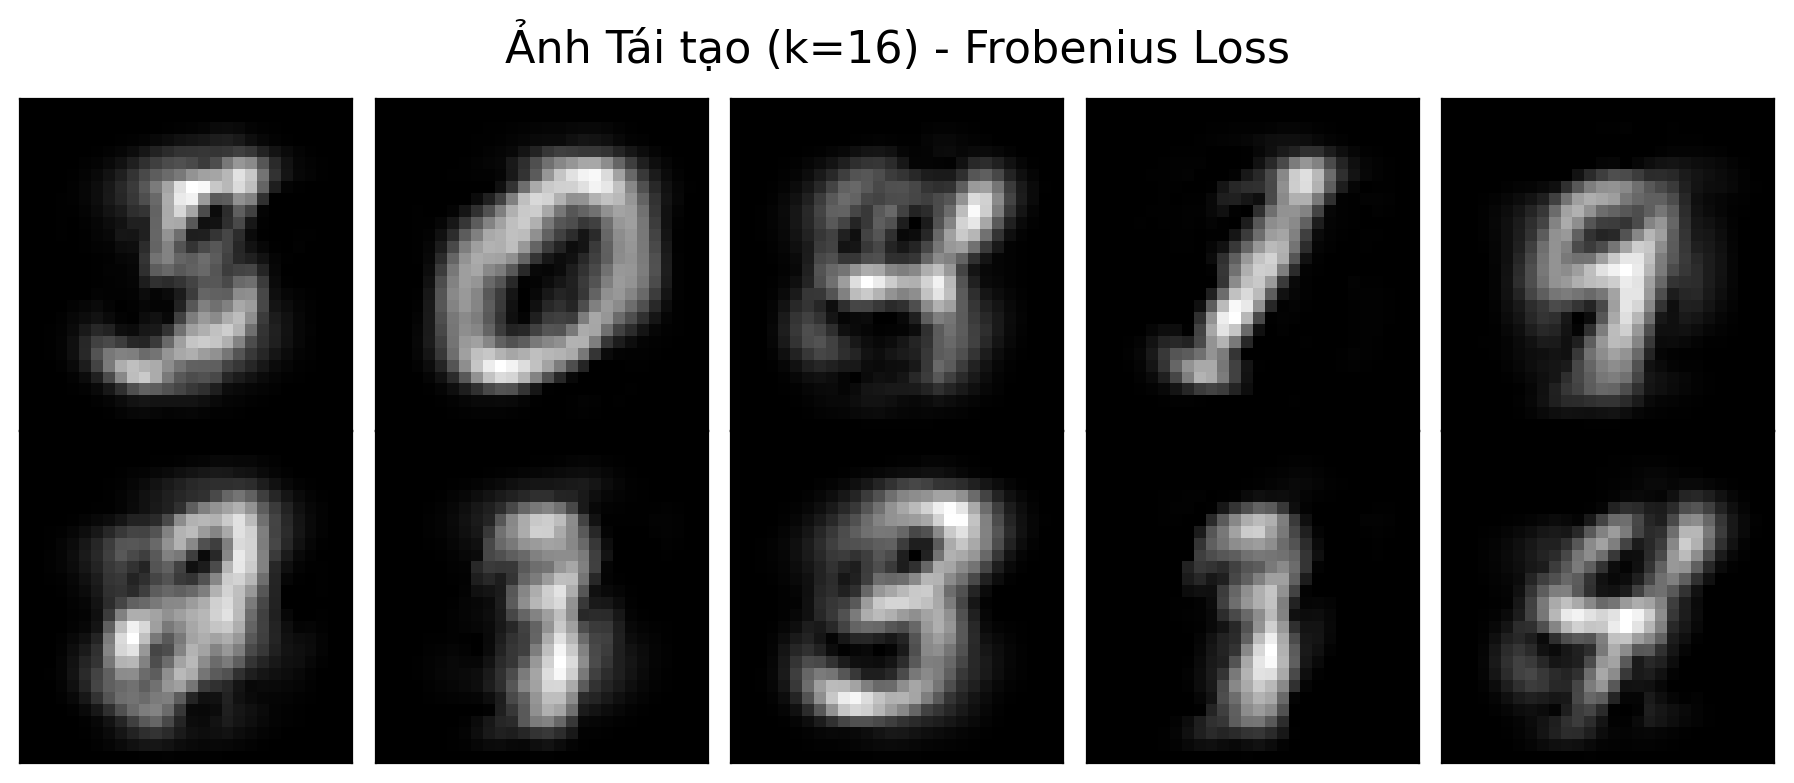

In [ ]:
# Tái tạo Frobenius
plot_gallery(f"Ảnh Tái tạo (k={k}) - Frobenius Loss", V_recon_frob, image_shape, n_col=5, n_row=2)
plt.show()

#### 8.5.3 Ảnh sau khi tái tạo - Kullback-Leibler ($W$ x $H$)

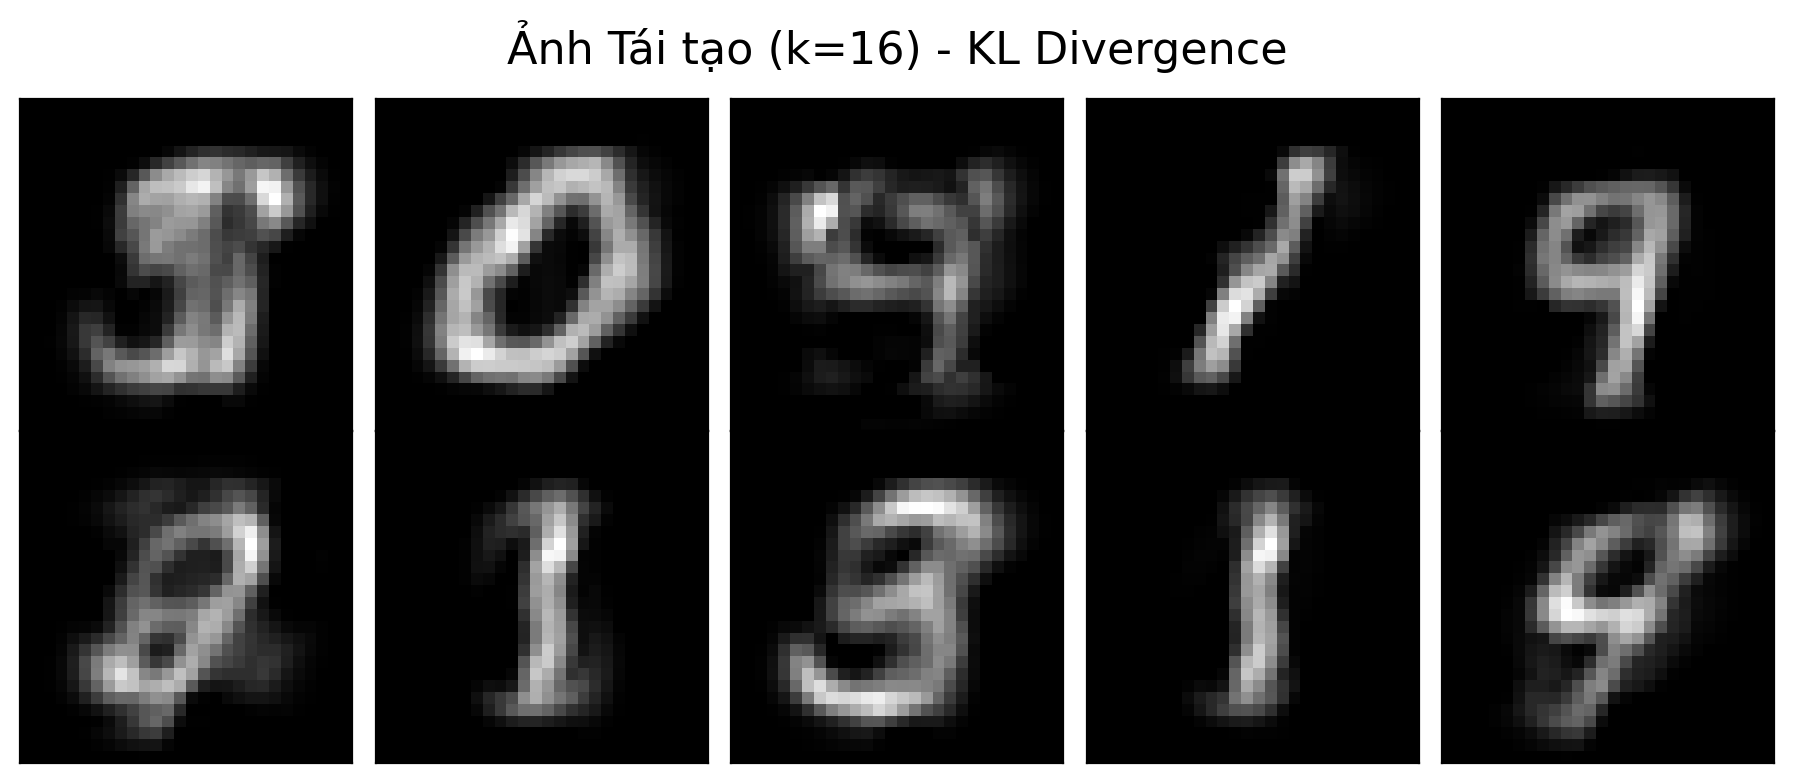

In [ ]:
# Tái tạo KL
plot_gallery(f"Ảnh Tái tạo (k={k}) - KL Divergence", V_recon_kl, image_shape, n_col=5, n_row=2)
plt.show()

#### 8.5.4 Ảnh sau khi tái tạo - Itakura-Saito ($W$ x $H$)

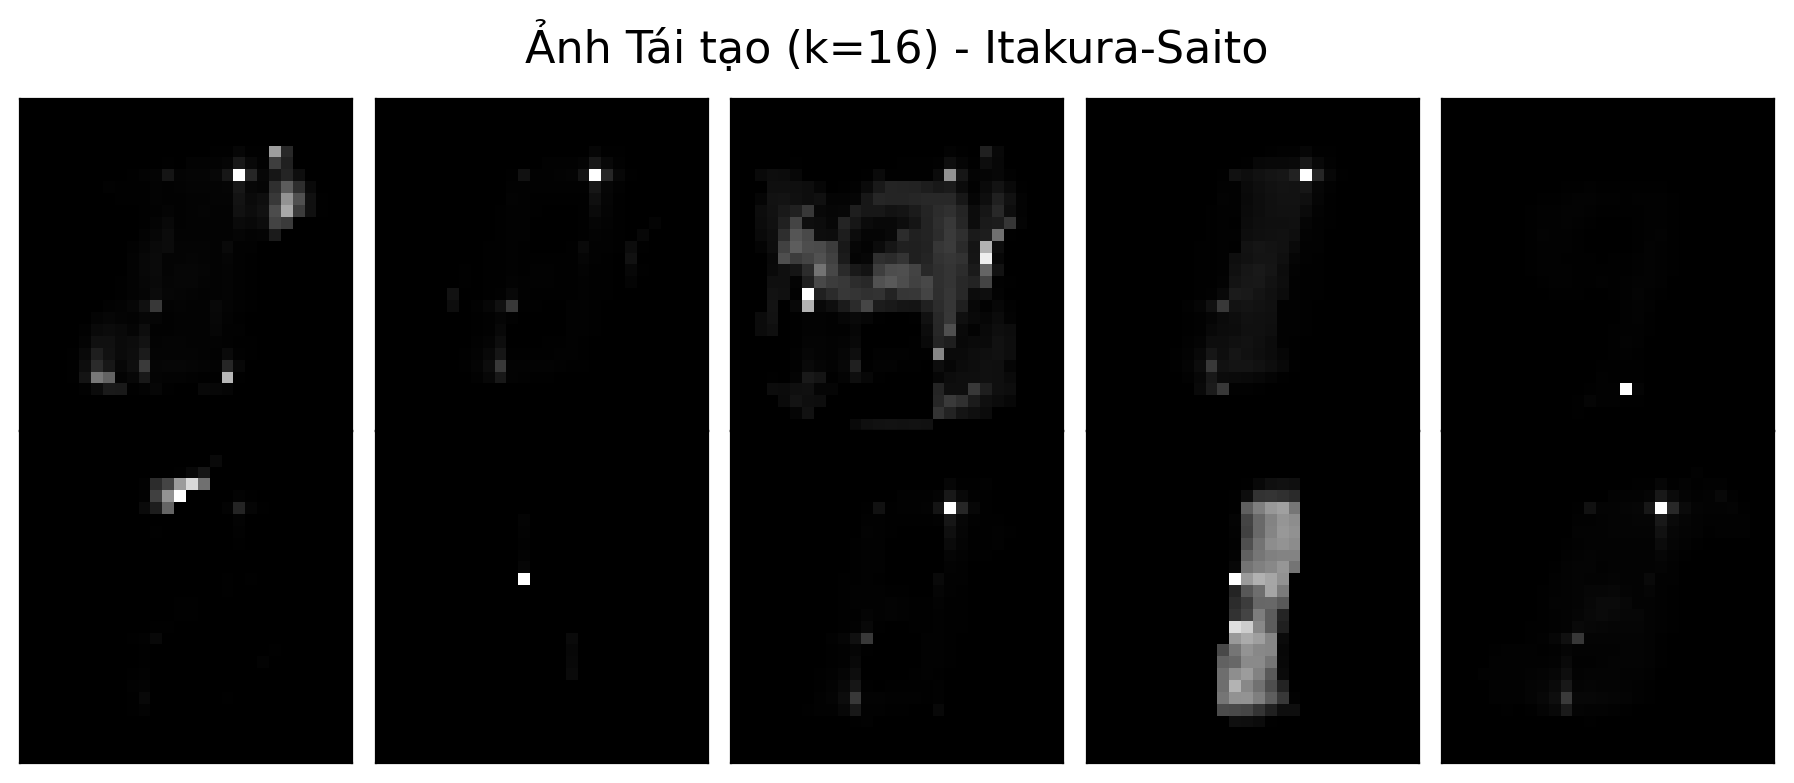

In [ ]:
# Tái tạo IS
plot_gallery(f"Ảnh Tái tạo (k={k}) - Itakura-Saito", V_recon_is, image_shape, n_col=5, n_row=2)
plt.show()

### 8.6 Phân tích định lượng - Tính toán MSE, MAE, R2

In [ ]:
# Tính toán MSE, MAE, R2 cho 10 ảnh mẫu
def calculate_metrics(V_true, V_recon):
    # Dùng .ravel() để làm phẳng ma trận thành vector 1D trước khi tính
    # V_true và V_recon đang có shape (10, 784)
    y_true = V_true.ravel()
    y_pred = V_recon.ravel()

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Tính toán cho cả 3 mô hình
metrics_frob = calculate_metrics(V_sample, V_recon_frob)
metrics_kl = calculate_metrics(V_sample, V_recon_kl)
# Tính toán các độ đo trên V_sample GỐC (không cộng epsilon)
metrics_is = calculate_metrics(V_sample, V_recon_is)

print("--- Đánh giá định lượng chất lượng Tái tạo (trên 10 mẫu) ---")
print("\nMô hình Frobenius:")
# Sử dụng \n (xuống dòng) và \t (hoặc dấu cách) để thụt vào
print(f"MSE={metrics_frob[0]:.6f}\nMAE={metrics_frob[1]:.6f}\nR2={metrics_frob[2]:.4f}")

print("\nMô hình Kullback-Leibler:")
print(f"MSE={metrics_kl[0]:.6f}\nMAE={metrics_kl[1]:.6f}\nR2={metrics_kl[2]:.4f}")

print("\nMô hình Itakura-Saito:")
print(f"MSE={metrics_is[0]:.6f}\nMAE={metrics_is[1]:.6f}\nR2={metrics_is[2]:.4f}")

--- Đánh giá định lượng chất lượng Tái tạo (trên 10 mẫu) ---

Mô hình Frobenius:
MSE=0.031684
MAE=0.090966
R2=0.6294

Mô hình Kullback-Leibler:
MSE=0.033652
MAE=0.084296
R2=0.6064

Mô hình Itakura-Saito:
MSE=50.109896
MAE=0.406789
R2=-585.1144


### 8.7 Phân tích và Đánh giá Kết quả Tái tạo - Trực quan hóa bằng hình ảnh
Việc trực quan hóa các ảnh được tái tạo (reconstruction) cung cấp bằng chứng rõ rệt nhất về hiệu quả thực sự của ba hàm mất mát khi áp dụng NMF.

Quan sát chung: Tất cả các ảnh tái tạo đều mờ hơn đáng kể so với ảnh gốc. Đây là điều hoàn toàn có thể dự đoán được, vì chúng ta đang thực hiện một tác vụ nén dữ liệu cực lớn: ép 784 đặc trưng (pixels) xuống chỉ còn $k=16$ thành phần cơ sở (components).

Tuy nhiên, chất lượng của sự "mờ" này lại khác biệt rõ rệt giữa các hàm loss:
1. Frobenius (Sklearn Frobenius):
   + Ảnh tái tạo bị mờ, nhòe và mất nhiều chi tiết.
   + Kết quả trông giống như một "phiên bản trung bình" (averaged version) của các chữ số, thay vì một chữ số cụ thể.
   + Lý do: Điều này tương ứng hoàn hảo với các "ảnh cơ sở" (components) mờ nhạt mà mô hình Frobenius đã học được (như đã thấy ở Mục 7.1).


2. Kullback-Leibler (Sklearn KL):
   + Kết quả vượt trội rõ rệt.
   + Mặc dù vẫn mờ, các ảnh tái tạo giữ lại được bản chất và hình dạng cốt lõi của chữ số gốc (ví dụ: số '0', '1', '9' vẫn rất dễ nhận diện).
   + Lý do: Điều này trực tiếp khẳng định rằng các "ảnh cơ sở" dạng nét chữ (parts-based components) mà KL học được (Mục 7.2) là có ý nghĩa nhất để biểu diễn dữ liệu.
   
3. Itakura-Saito (Sklearn IS):
   + Kết quả tái tạo là thất bại hoàn toàn (total failure) về mặt trực quan.
   + Ảnh tái tạo chỉ là nhiễu (noise), không thể nhận diện được bất kỳ cấu trúc chữ số nào.
   + Lý do: Điều này đã được dự đoán từ Mục 7.3 vì các "ảnh cơ sở" của IS là nhiễu, nên tổ hợp tuyến tính của chúng cũng chỉ tạo ra nhiễu.
   
💡 Kết luận Thực nghiệm
+ Thực nghiệm tái tạo ảnh này đã xác nhận mạnh mẽ kết luận từ Mục 7: Hàm mất mát Kullback-Leibler (KL) là lựa chọn tối ưu cho bài toán trích xuất đặc trưng và tái tạo dữ liệu ảnh MNIST.

### 8.8 Phân tích và Đánh giá Kết quả Tái tạo - So sánh dựa trên các chỉ số MSE, MAE, R2
Các chỉ số định lượng (MSE, MAE, R2) này cung cấp bằng chứng khách quan, xác nhận mạnh mẽ các phân tích trực quan của chúng ta về hiệu quả của ba hàm mất mát khi áp dụng NMF trên dữ liệu ảnh MNIST.

Phân tích chi tiết:
 1. Mô hình Frobenius (MSE: 0.031684 | MAE: 0.090966 | R2: 0.6294):

    + Kết quả: Mô hình Frobenius đạt MSE thấp nhất và R2 cao nhất.

    + Nhận xét: Điều này là hoàn toàn có thể dự đoán được. Hàm mất mát Frobenius về bản chất chính là tối ưu hóa tổng Sai số Bình phương (Sum of Squared Errors). Do đó, không ngạc nhiên khi nó "chiến thắng" trên các thước đo dựa trên sai số bình phương (như MSE và R2).

 2. Mô hình Kullback-Leibler (MSE: 0.033652 | MAE: 0.084296 | R2: 0.6064):

    + Kết quả: Mô hình KL có MSE và R2 chỉ cao hơn một chút không đáng kể so với Frobenius. Tuy nhiên, nó đạt được MAE (Sai số tuyệt đối trung bình) thấp nhất.

    + Nhận xét: Điều này rất thú vị. Nó cho thấy rằng mặc dù lỗi bình phương (MSE) của KL cao hơn, nhưng lỗi tuyệt đối (MAE) của nó lại thấp hơn. Điều này ngụ ý rằng mô hình KL (tối ưu hóa phân kỳ thông tin) tạo ra ít lỗi "cực lớn" (extreme outliers) hơn so với mô hình Frobenius (vốn rất nhạy cảm với outlier do cơ chế bình phương).

3. Mô hình Itakura-Saito (MSE: 50.109896 | MAE: 0.406789 | R2: -585.1144):

    + Kết quả: Mô hình IS thất bại hoàn toàn trên cả ba chỉ số.

    + Nhận xét: Giá trị MSE cực kỳ cao (50.10) và chỉ số R2 âm sâu (-585.11) là bằng chứng định lượng rõ ràng nhất. Chỉ số R2 âm có nghĩa là mô hình tái tạo còn tệ hơn rất nhiều so với việc chỉ dự đoán một ảnh trung bình (ảnh xám). Điều này xác nhận kết luận trực quan của chúng ta: IS (vốn được thiết kế cho âm thanh và bất biến tỷ lệ) hoàn toàn không phù hợp để tái tạo dữ liệu ảnh MNIST vốn có nhiều giá trị 0.

💡 Đánh giá chung và Kết luận quan trọng
Các số liệu này làm nổi bật sự đánh đổi kinh điển trong học máy giữa Độ chính xác tái tạo (Reconstruction Accuracy) và Chất lượng đặc trưng (Feature Quality).

+ Nếu mục tiêu duy nhất là tái tạo lại ảnh sao cho giống pixel-với-pixel nhất, Frobenius là người chiến thắng về mặt số liệu (MSE thấp nhất).

+ Tuy nhiên, Kullback-Leibler đã tạo ra các "ảnh cơ sở" (components) có ý nghĩa, sắc nét và mang tính "nét chữ" (parts-based) vượt trội (như đã thấy ở Mục 7.2).

+ Kết luận: Thực nghiệm định lượng này chứng minh rằng, để đạt được chất lượng đặc trưng trực quan tốt nhất (KL), chúng ta chỉ phải hy sinh một lượng rất nhỏ hiệu suất tái tạo (MSE chỉ tăng từ 0.0316 lên 0.0336). Đây là một sự đánh đổi hoàn toàn xứng đáng, khẳng định Kullback-Leibler là hàm mất mát tối ưu nhất cho bài toán trích xuất đặc trưng trên dữ liệu ảnh MNIST.